In [2]:
# for data handling and plotting
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import seaborn as sns
# packages to predict anomalies 
#from xgboost import XGBClassifier
#from xgboost import plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr
from pandas.plotting import scatter_matrix

# for balancing data
from imblearn.over_sampling import SMOTE

# for classification
from sklearn import metrics, model_selection
from sklearn.metrics import classification_report,roc_auc_score,accuracy_score,confusion_matrix
from sklearn.metrics import roc_curve,f1_score,precision_recall_fscore_support

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# for regression
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn import metrics, model_selection

%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
cryptocompare = pd.read_csv('cryptocompare_anomalies_table.csv',index_col=0)
coinmarketcap = pd.read_csv('coinmarketcap_anomalies_table.csv',index_col=0)
coinbase = pd.read_csv('coinbase_anomalies_table.csv',index_col=0)
bitstamp = pd.read_csv('bitstamp_anomalies_table.csv',index_col=0)
kraken = pd.read_csv('kraken_anomalies_table.csv',index_col=0)

cryptocompare_prices = pd.read_csv('cc_trends_data.csv',index_col=0)
coinmarketcap_prices = pd.read_csv('cmc_trends_data.csv',index_col=0)
kraken_prices = pd.read_csv('kraken_trends_data.csv',index_col=0)
bitstamp_prices = pd.read_csv('bitstamp_trends_data.csv',index_col=0)
coinbase_prices = pd.read_csv('coinbase_trends_data.csv',index_col=0)

social = pd.read_csv('social_anomalies_table.csv',index_col=0)
blockchain = pd.read_csv('blockchain_anomalies_table.csv',index_col=0)
blockchain_data = pd.read_csv('blockchain_for_modeling.csv',index_col=0)
social_data = pd.read_csv('social_for_modeling.csv',index_col=0)

# index to datetime
blockchain_data.index = pd.to_datetime(blockchain_data.index)
social_data.index = pd.to_datetime(social_data.index)

cryptocompare_proba = np.load('cryptocompare_proba.npy')
coinmarketcap_proba = np.load('coinmarketcap_proba.npy')
kraken_proba = np.load('kraken_proba.npy')
birstamp_proba = np.load('bitstamp_proba.npy')
coinbase_proba = np.load('coinbase_proba.npy')
blockchain_proba = np.load('blockchain_proba.npy')
social_proba = np.load('social_proba.npy')

In [7]:
social_data

,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,...,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-05-26,5634,2370,5851,261865,722156,53665,73188,141558,26634,66635,...,554.38,351.56,8437.50,15817,9804,1765,229,8282,686,3537
2017-05-27,5827,2427,5990,268695,746321,54589,75038,146799,27456,69720,...,330.62,172.08,4130.02,15853,9820,1766,234,8283,688,3539
2017-05-28,5873,2443,6090,272055,762354,55312,76280,151348,27911,71133,...,336.20,138.09,3314.15,15876,9837,1766,234,8284,685,3543
2017-05-29,5896,2458,6199,275385,777977,55917,77388,154664,28556,72482,...,366.41,267.86,6428.57,15904,9845,1770,235,8286,686,3545
2017-05-30,5958,2471,6318,279305,793113,56560,78481,158590,29580,73833,...,451.25,278.21,6676.97,15932,9866,1778,234,8291,686,3546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-03,222055,88512,63352,6017150,22023350,948965,1391355,7263725,667237,6449200,...,284.29,114.76,2754.22,43935,25187,4190,322,11711,903,5132
2019-01-04,222627,88576,63378,6025120,22036511,949234,1391872,7284317,667540,6455089,...,177.89,114.80,2755.10,43964,25202,4189,320,11722,903,5136
2019-01-05,222911,88627,63411,6030060,22049994,949459,1392278,7304688,667841,6460321,...,110.78,122.16,2931.80,43980,25204,4190,317,11731,903,5137


## Anomaly charts 

In [319]:
def anomaly_chart(df1,df2,close,title):
    # Converting the index as date
    df1.index = pd.to_datetime(df1.index)
    df2.Date = pd.to_datetime(df2.Date)
    # link close price to anomolous dates
    common = \
       set.intersection(set(df1.index), set(df2.Date))
    filter1 = df1[df1.index.isin(common)]
    filter1 = filter1[[close]]

    # plot price
    # Alter size for the plot
    plt.subplots(dpi=100,figsize=(16,5))
    # plot all close price data
    plt.plot(df1.index, df1[close],  alpha=0.5)
    # set x-axis label and specific size
    plt.xlabel('Date',size=16)
    # set y-axis label and specific size
    plt.ylabel('Close Price',size=16)
    # set plot title with specific size
    plt.title('Detected Anomalies for '+title,size=16)

    # plot anomalies 
    plt.scatter(filter1.index, filter1[close], color="red")
    plt.show()

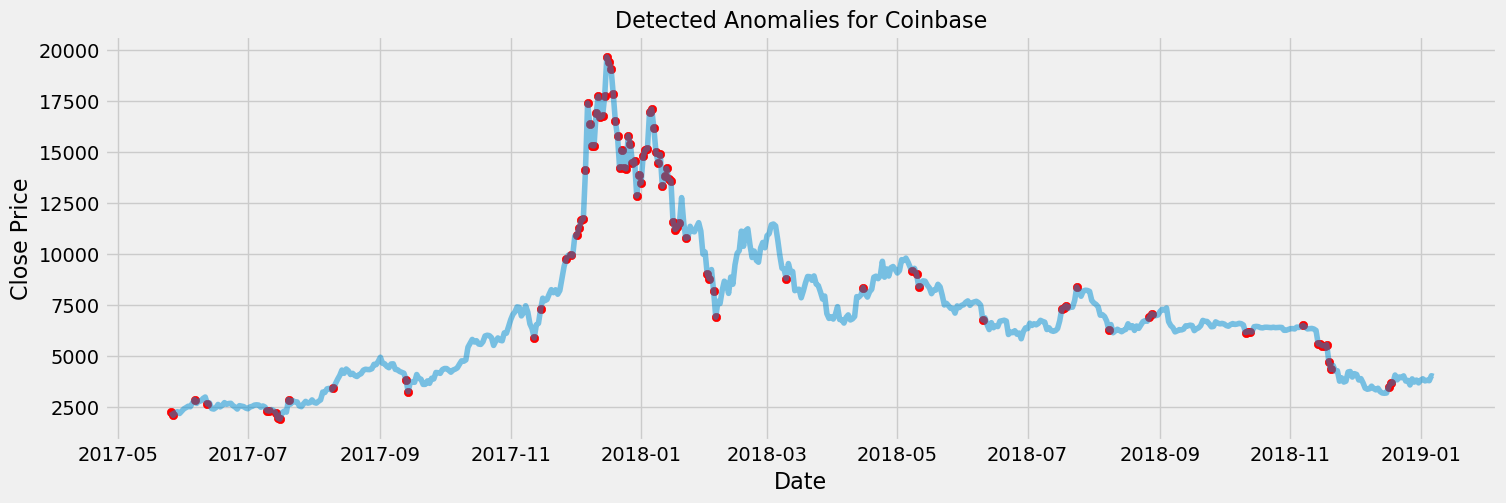

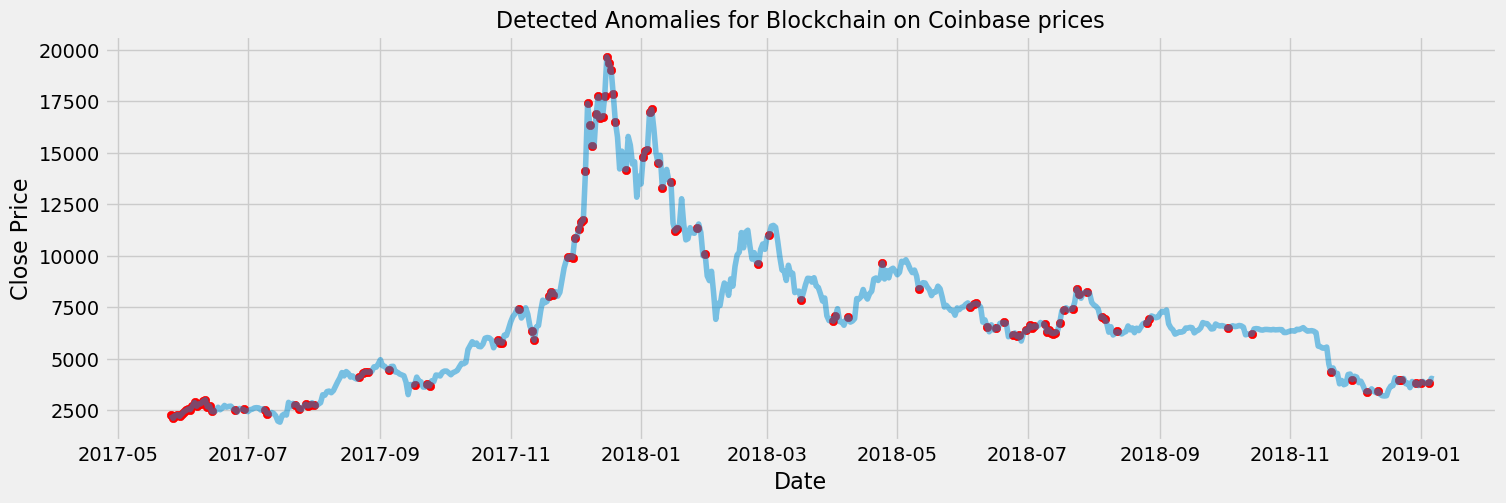

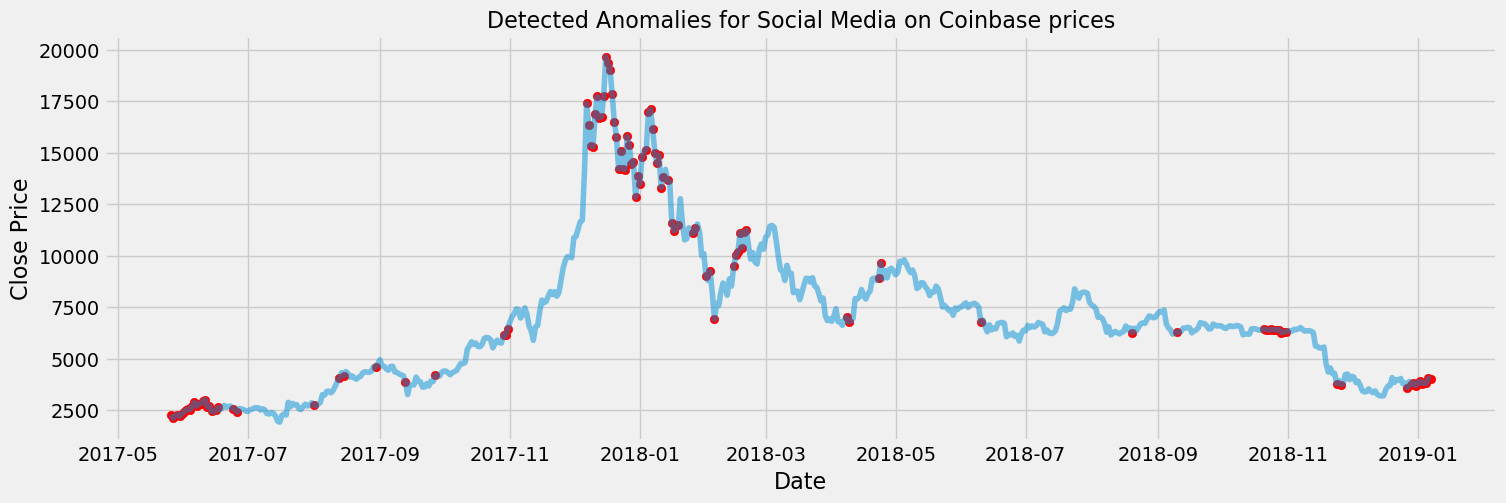

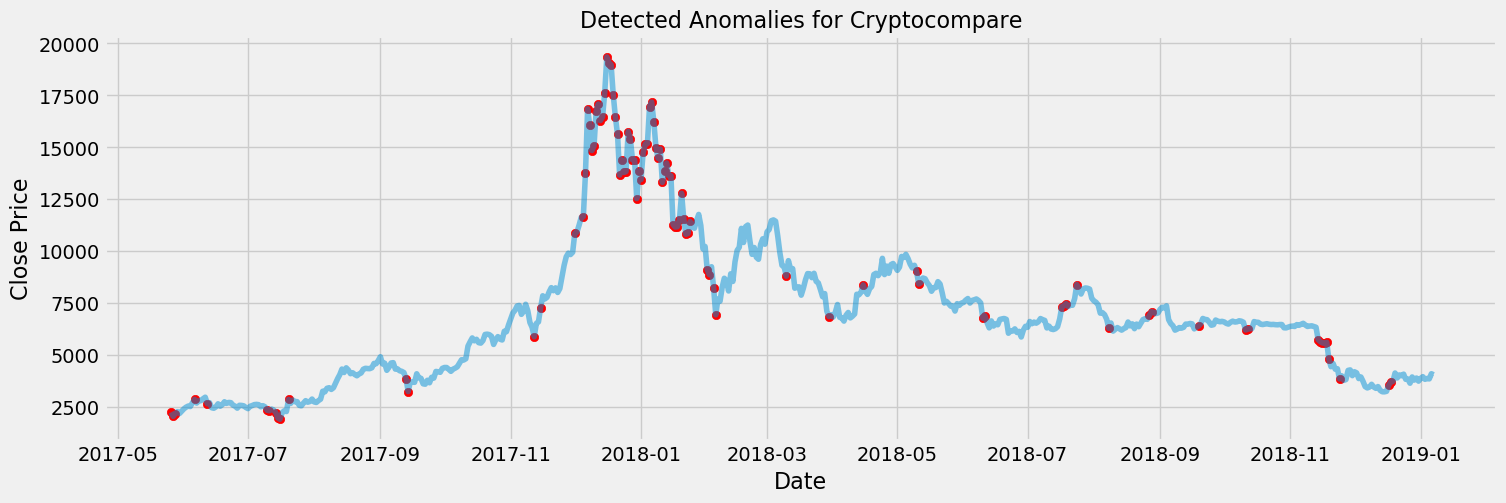

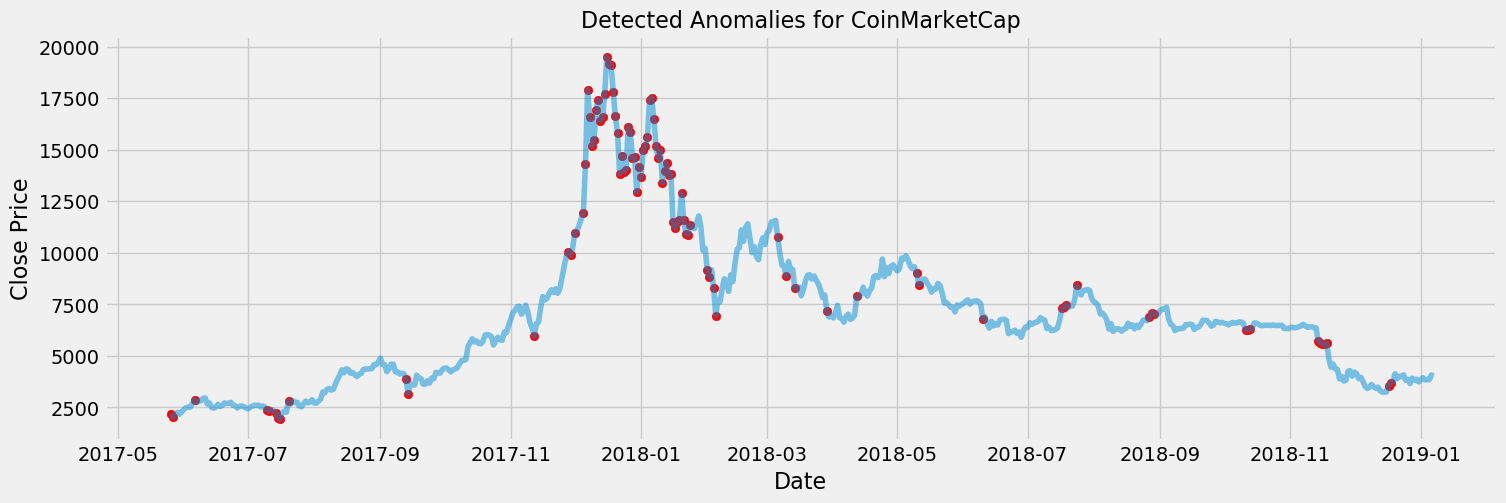

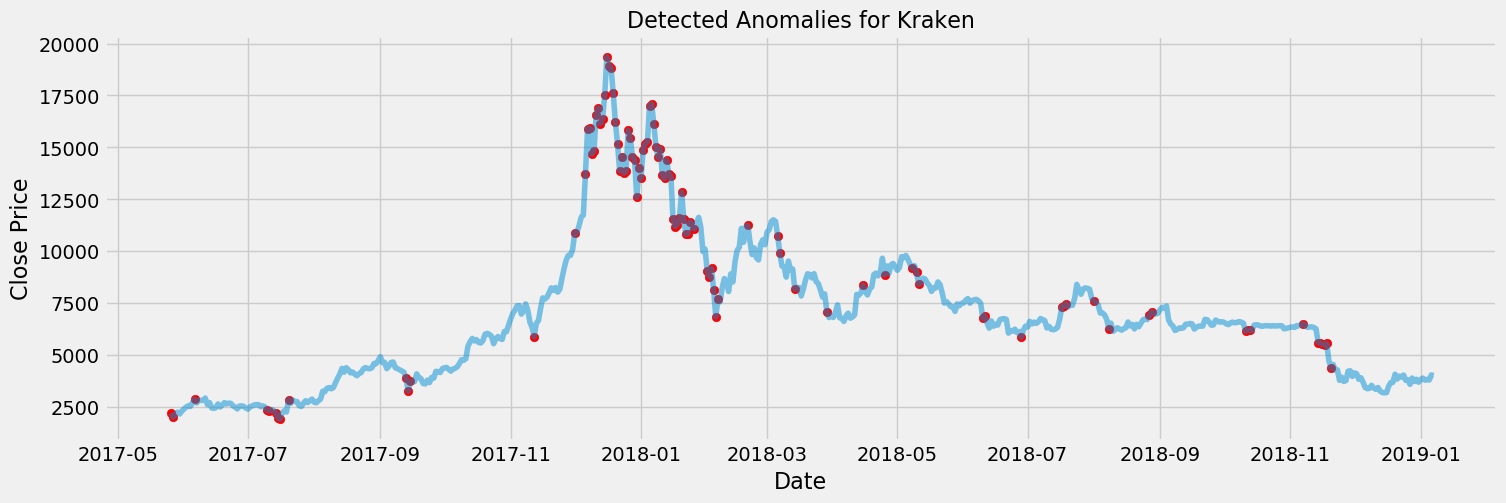

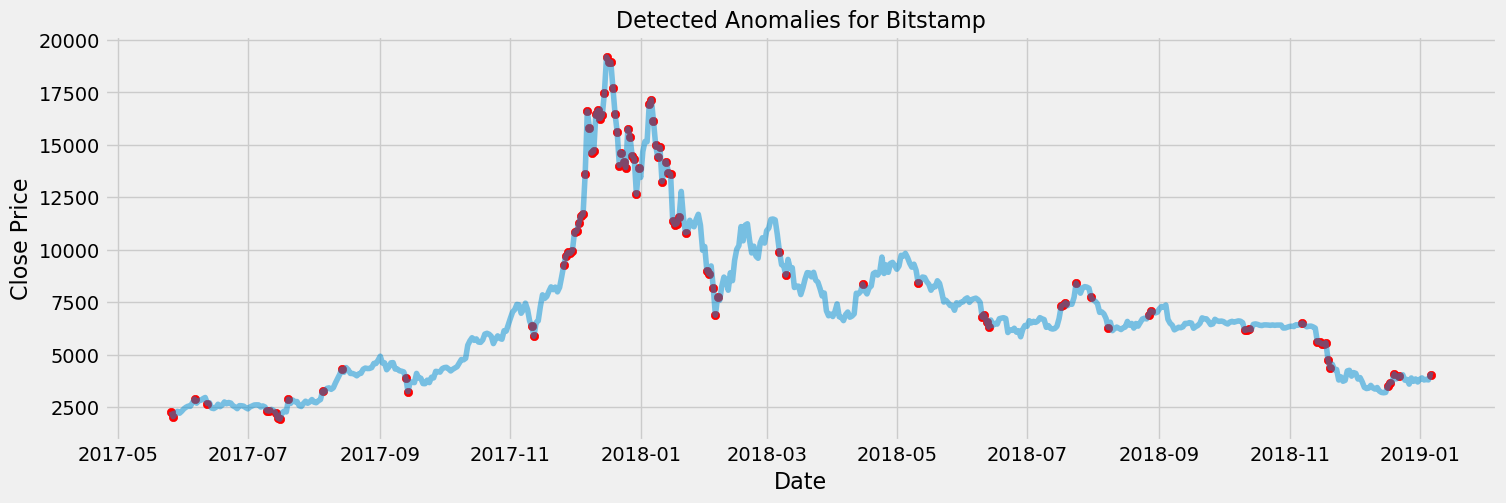

In [320]:
anomaly_chart(coinbase_prices,coinbase,'Close','Coinbase')
anomaly_chart(coinbase_prices,blockchain,'Close','Blockchain on Coinbase prices')
anomaly_chart(coinbase_prices,social,'Close','Social Media on Coinbase prices')

anomaly_chart(cryptocompare_prices,cryptocompare,'close','Cryptocompare')
anomaly_chart(coinmarketcap_prices,coinmarketcap,'close','CoinMarketCap')
anomaly_chart(kraken_prices,kraken,'Close','Kraken')
anomaly_chart(bitstamp_prices,bitstamp,'Close','Bitstamp')


In [358]:
def monthly_effect(df, close, date,df_title): 
    pct_return = (df[close].pct_change()*100).reset_index()
    pct_return['Month'] = pct_return[date].dt.month
    pct_return['Day'] = pct_return[date].dt.day
    pct_return.groupby('Month')['Close'].agg('sum').plot(kind='bar')
    plt.title('Pct change over months'+' '+df_title)
    plt.ylabel('Pct Change (%)')
    plt.show()
    pct_return.groupby('Day')['Close'].agg('sum').plot(kind='bar')
    plt.title('Pct change over days'+' '+df_title)
    plt.ylabel('Pct Change (%)')
    plt.show()

In [360]:
# also check if this is effects happen over different years - USE TOTAL DATA for prices
# lets say for January always down --> check if theres more anomalies at that time usually + manipulation 
# compare differnt coins 

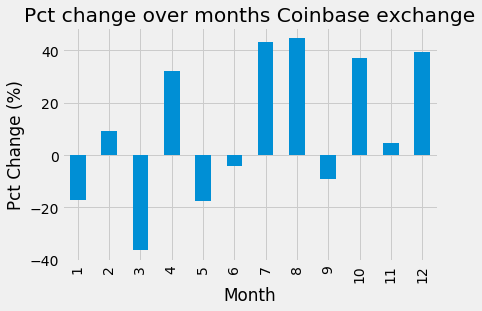

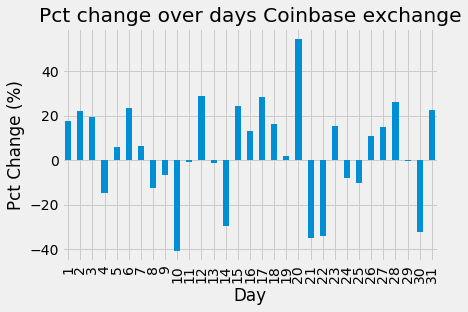

In [359]:
monthly_effect(coinbase_prices, 'Close', 'Date','Coinbase exchange')

## Anomaly summary

In [13]:
# same anomalies across price datasets
same_price_anomalies = set(kraken.Date)&set(coinbase.Date)&set(cryptocompare.Date)&set(coinmarketcap.Date)&set(bitstamp.Date)
# using coinbase as the most reliable we examine which anomaly dates deviate from it
coinbase_cc_difference = set(coinbase.Date) - set(cryptocompare.Date)
coinbase_cmc_difference = set(coinbase.Date) - set(coinmarketcap.Date)
coinbase_bitstamp_difference = set(coinbase.Date) - set(bitstamp.Date)
coinbase_kraken_difference = set(coinbase.Date) - set(kraken.Date)
# what anomalies other datasets have that coinbase does not 
cc_coinbase_difference = set(cryptocompare.Date) - set(coinbase.Date) 
cmc_coinbase_difference = set(coinmarketcap.Date) - set(coinbase.Date) 
bitstamp_coinbase_difference = set(bitstamp.Date) - set(coinbase.Date) 
kraken_coinbase_difference = set(kraken.Date) - set(coinbase.Date)
# blockchain and social media difference to coinbase and eachother
coinbase_block_difference = set(coinbase.Date) - set(blockchain.Date)
block_coinbase_difference = set(blockchain.Date) - set(coinbase.Date)
coinbase_social_difference = set(coinbase.Date) - set(social.Date)
social_coinbase_difference = set(social.Date) - set(coinbase.Date)
block_social_difference = set(blockchain.Date) - set(social.Date)
social_block_difference = set(social.Date) - set(blockchain.Date)
# blockchain, social, and coinbase same anomalies
coinbase_social_blockSAME = set(coinbase.Date) & set(social.Date) & set(blockchain.Date)
social_coinbase_same = set(social.Date) & set(coinbase.Date)
block_social_same = set(blockchain.Date) & set(social.Date)
block_coinbase_same = set(coinbase.Date) & set(blockchain.Date)
unique_dates = pd.concat([coinbase.Date, social.Date, blockchain.Date],axis=0)

print('CoinMarketCap number of unique date anomalies: ',len(coinmarketcap.Date.unique()))
print('Cryptocompare number of unique date anomalies: ',len(cryptocompare.Date.unique()))
print('Coinbase number of unique date anomalies: ',len(coinbase.Date.unique()))
print('Bitstamp number of unique date anomalies: ',len(bitstamp.Date.unique()))
print('Kraken number of unique date anomalies: ',len(kraken.Date.unique()),'\n')

print('Same anomalies between all price datasets: ', len(same_price_anomalies),'\n')

#print('Coinbase different anomalies to cryptocompare: ',len(coinbase_cc_difference))
#print('Coinbase different anomalies to coinmarketcap: ',len(coinbase_cmc_difference))
#print('Coinbase different anomalies to bitstamp: ',len(coinbase_bitstamp_difference))
#print('Coinbase different anomalies to kraken: ',len(coinbase_kraken_difference),'\n')

print('Cryptocompare different anomalies to Coinbase: ',len(cc_coinbase_difference))
print('Coinmarketcap different anomalies to Coinbase: ',len(cmc_coinbase_difference))
print('Bitstamp different anomalies to Coinbase: ',len(bitstamp_coinbase_difference))
print('Kraken different anomalies to Coinbase: ',len(kraken_coinbase_difference),'\n')

print('Blockchain number of unique date anomalies: ', len(blockchain.Date.unique()))
print('Social media number of unique date anomalies: ', len(social.Date.unique()))
print('Blockchain, social, & coinbase number of same date anomalies: ',len(set(coinbase.Date) & set(social.Date) & set(blockchain.Date)))
print('Blockchain, & coinbase number of same date anomalies: ',len(set(coinbase.Date) & set(blockchain.Date)))
print('Social, & coinbase number of same date anomalies: ',len(set(coinbase.Date) & set(social.Date)),'\n')

print('Coinbase prices, blockchain & social concatonated - unique anomalies: ', len(unique_dates.unique()),'\n')

print('Coinbase - blockchain number of different anomalies: ', len(set(coinbase.Date) - set(blockchain.Date)))
print('Coinbase - social number of different anomalies: ', len(set(coinbase.Date) - set(social.Date)))
print('Blockchain - coinbase number of different anomalies: ', len(set(blockchain.Date) - set(coinbase.Date)))
print('Social - coinbase number of different anomalies: ', len(set(social.Date) - set(coinbase.Date)))
print('Blockchian - social number of different anomalies: ', len(set(blockchain.Date) - set(social.Date)))
print('Social - blockchian number of different anomalies: ', len(set(social.Date) - set(blockchain.Date)))

CoinMarketCap number of unique date anomalies:  95
Cryptocompare number of unique date anomalies:  97
Coinbase number of unique date anomalies:  97
Bitstamp number of unique date anomalies:  104
Kraken number of unique date anomalies:  101 

Same anomalies between all price datasets:  71 

Cryptocompare different anomalies to Coinbase:  10
Coinmarketcap different anomalies to Coinbase:  11
Bitstamp different anomalies to Coinbase:  16
Kraken different anomalies to Coinbase:  18 

Blockchain number of unique date anomalies:  130
Social media number of unique date anomalies:  116
Blockchain, social, & coinbase number of same date anomalies:  25
Blockchain, & coinbase number of same date anomalies:  40
Social, & coinbase number of same date anomalies:  48 

Coinbase prices, blockchain & social concatonated - unique anomalies:  232 

Coinbase - blockchain number of different anomalies:  57
Coinbase - social number of different anomalies:  49
Blockchain - coinbase number of different anomal

## Exchange Analysis - does volume match up to price?

In [14]:
# get variable name
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def ohlc_plot(df,Open,High,Low,Close,Volume,title):
    fig, ax1 = plt.subplots(figsize=(16, 6))

    width=1
    width2=0.1
    df.index = pd.to_datetime(df.index)
    pricesup=df[df[Close]>=df[Open]]
    pricesdown=df[df[Close]<df[Open]]

    ax1.bar(pricesup.index,pricesup[Close]-pricesup[Open],width,bottom=pricesup[Open],color='g')
    ax1.bar(pricesup.index,pricesup[High]-pricesup[Close],width2,bottom=pricesup[Close],color='g')
    ax1.bar(pricesup.index,pricesup[Low]-pricesup[Open],width2,bottom=pricesup[Open],color='g')

    ax1.bar(pricesdown.index,pricesdown[Close]-pricesdown[Open],width,bottom=pricesdown[Open],color='r')
    ax1.bar(pricesdown.index,pricesdown[High]-pricesdown[Open],width2,bottom=pricesdown[Open],color='r')
    ax1.bar(pricesdown.index,pricesdown[Low]-pricesdown[Close],width2, bottom=pricesdown[Close],color='r')
    plt.grid()

    ax2 = ax1.twinx() 
    ax2.bar(x= df.index,height=df[Volume],alpha=0.4)
    plt.title('Bitcoin OHLC chart vs Volume for '+title, size=16)
    fig.tight_layout()
    plt.show()

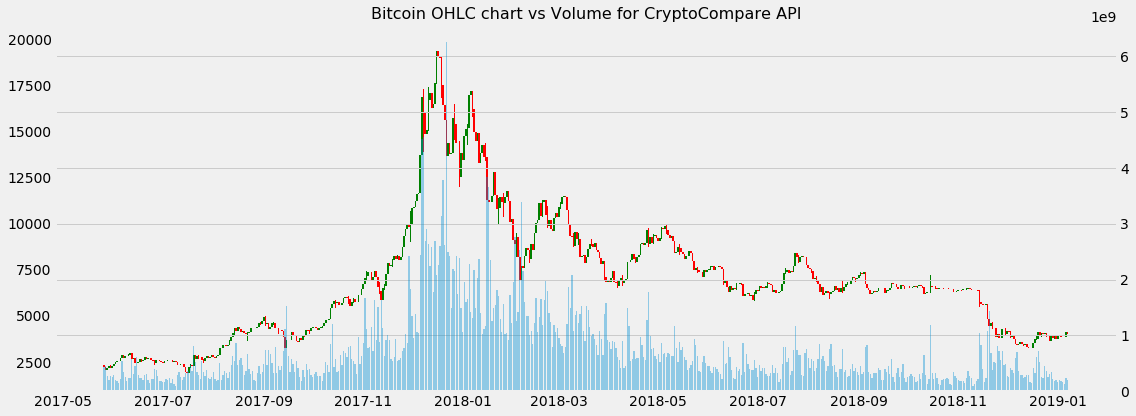

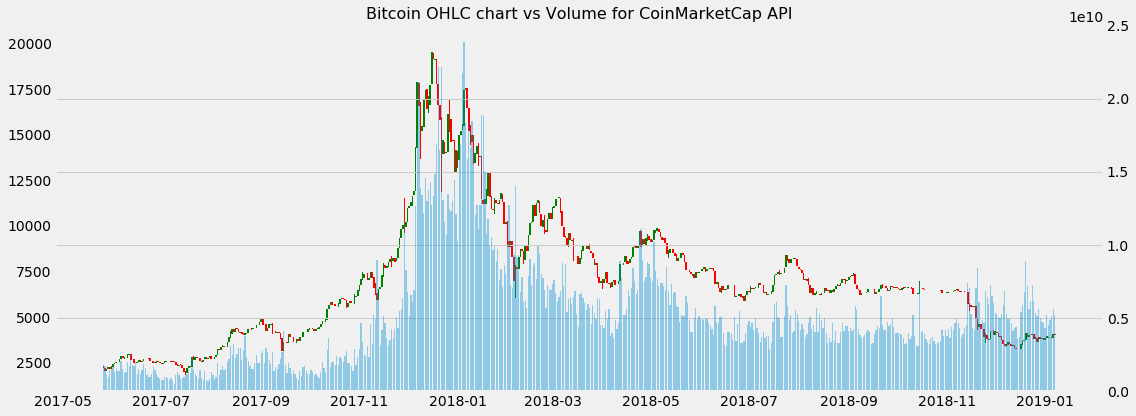

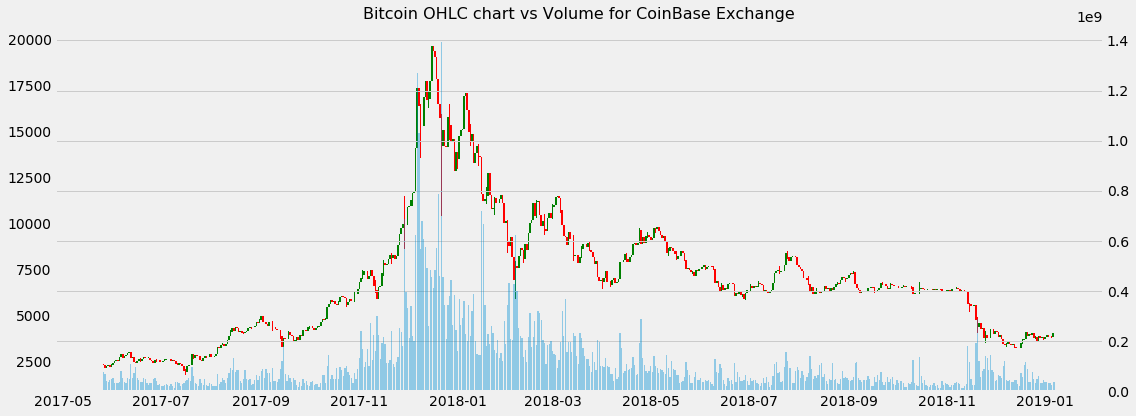

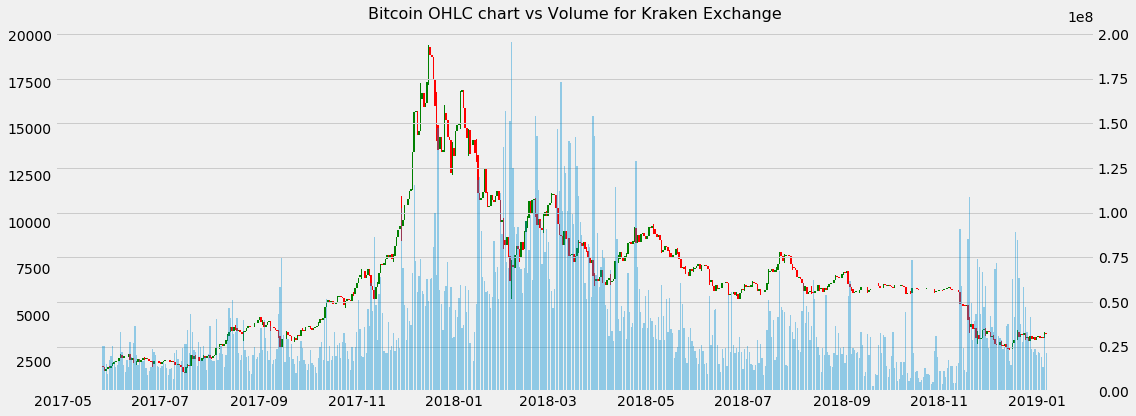

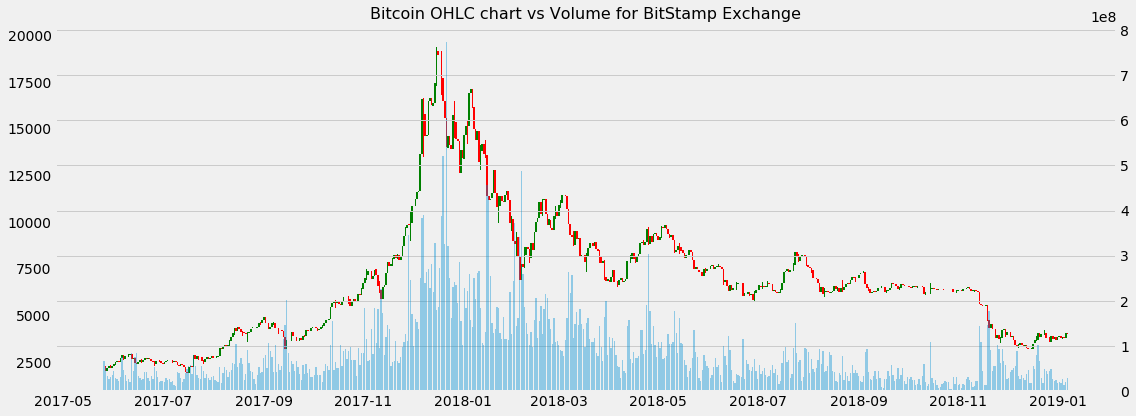

In [15]:
ohlc_plot(cryptocompare_prices,'open','high','low','close','volumeto','CryptoCompare API')
ohlc_plot(coinmarketcap_prices,'open','high','low','close','volume','CoinMarketCap API')
ohlc_plot(coinbase_prices,'Open','High','Low','Close','Volume (Currency)','CoinBase Exchange')
ohlc_plot(kraken_prices,'Open','High','Low','Close','Volume (Currency)','Kraken Exchange')
ohlc_plot(bitstamp_prices,'Open','High','Low','Close','Volume (Currency)','BitStamp Exchange')

In [366]:
coinmarketcap_prices.columns

Index(['open', 'high', 'low', 'close', 'volume', 'CCI', 'ichimoku_leadSpanA',
       'ichimoku_leadSpanB', 'MACD', 'MACD_diff', 'MACD_signal',
       'AwesomeOscillator', 'KAMA', 'RateofChange', 'RSI_7', 'RSI_14',
       'StochasticOscillator', 'stoch_signal', 'TrueStrenghtIndex',
       'UltimateOscilator', 'williamsR', 'Accum_Distrubution', 'ForceIndex',
       'AvgTrueRange', 'BollingerHighBand', 'BHB_indicator',
       'BollingerLowBand', 'BLB_indicator', 'BC_middleBand', 'BC_percBand',
       'BCB_width', 'sma_5', 'sma_10', 'sma_20', 'sma_30', 'sma_50', 'sma_100',
       'sma_200', 'ema_5', 'ema_10', 'ema_20', 'ema_30', 'ema_50', 'ema_100',
       'ema_200', 'vwma'],
      dtype='object')

## Exchanges volume correlation 

Text(0.5, 1, 'Correlation Matrix between all Volumes across datasets')

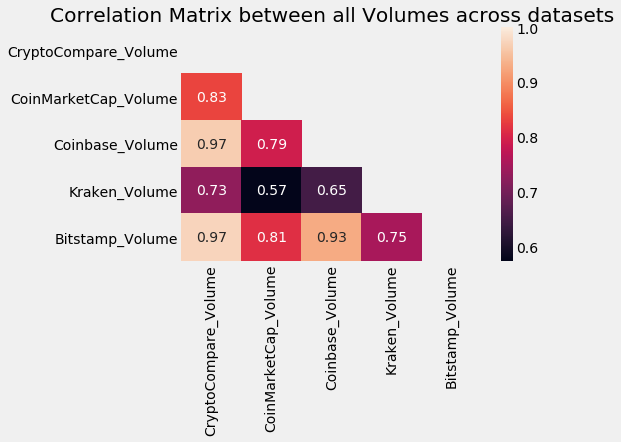

In [16]:
all_volumes = pd.concat([cryptocompare_prices['volumeto'],coinmarketcap_prices['volume'],coinbase_prices['Volume (Currency)'],kraken_prices['Volume (Currency)'],bitstamp_prices['Volume (Currency)']],axis=1)
all_volumes.columns = ['CryptoCompare_Volume','CoinMarketCap_Volume','Coinbase_Volume','Kraken_Volume','Bitstamp_Volume']
corr = all_volumes.corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix)
plt.title('Correlation Matrix between all Volumes across datasets')

## T-test's
#### Is sub-dataset with anomalies significantly different to sub-dataset without anomalies?
- this function goes throgh every column/feature in the dataset, creates 2 subsets (1 with and without anomalies), runs Welch’s t-test, and displays only features with p <= 0.05

In [52]:
def t_test(df1,df2,name):
    counter = 0
    # make a new column if date was identified as an anomaly
    anomaly_dates_modeling = df1.iloc[:,0]
    df2['anomaly'] = np.where(df2.index.isin(anomaly_dates_modeling), 1, 0)
    # iterate over dataframe series 
    for series in df2.columns[:-1]:
        # a = subset with anomalies, b = subset without anomalies 
        a = df2[df2.anomaly==1][series]
        b = df2[df2.anomaly==0][series]
        # perform Welch’s t-test
        t,p = stats.ttest_ind(a,b,equal_var=False)
        if p <= 0.05:
            counter = counter + 1 
            print('T-test for ' + name +' '+ series+': ')
            print("ttest_ind:            t = %g  p = %g" % (round(t,2), p))
    print('Number of subsets that are significantly different: ', counter)
    print('Total number of features: ', len(df2.columns[:-1]))
# T-test code from https://stackoverflow.com/questions/22611446/perform-2-sample-t-test

**Coinbase price dataset**

In [53]:
t_test(coinbase,coinbase_prices,'Coinbase dataset')

T-test for Coinbase dataset Open: 
ttest_ind:            t = 8.28  p = 4.48165e-13
T-test for Coinbase dataset High: 
ttest_ind:            t = 8.41  p = 2.33375e-13
T-test for Coinbase dataset Low: 
ttest_ind:            t = 7.7  p = 8.02519e-12
T-test for Coinbase dataset Close: 
ttest_ind:            t = 8.04  p = 1.49305e-12
T-test for Coinbase dataset Volume (Currency): 
ttest_ind:            t = 7.73  p = 9.11735e-12
T-test for Coinbase dataset CCI: 
ttest_ind:            t = -2.21  p = 0.0289514
T-test for Coinbase dataset ichimoku_leadSpanA: 
ttest_ind:            t = 8.39  p = 2.28355e-13
T-test for Coinbase dataset ichimoku_leadSpanB: 
ttest_ind:            t = 7.41  p = 2.34431e-11
T-test for Coinbase dataset MACD: 
ttest_ind:            t = 5.06  p = 1.88413e-06
T-test for Coinbase dataset MACD_diff: 
ttest_ind:            t = -2.45  p = 0.0158509
T-test for Coinbase dataset MACD_signal: 
ttest_ind:            t = 6.49  p = 3.15811e-09
T-test for Coinbase dataset AwesomeOsc

In [54]:
pd.set_option('display.max_columns', 100)
print('Subset with anomalies:')
display(coinbase_prices[coinbase_prices.anomaly==1].describe())
print('Subset without anomalies:','\n')
coinbase_prices[coinbase_prices.anomaly==0].describe()

Subset with anomalies:


,Open,High,Low,Close,Volume (Currency),CCI,ichimoku_leadSpanA,ichimoku_leadSpanB,MACD,MACD_diff,MACD_signal,AwesomeOscillator,KAMA,RateofChange,RSI_7,RSI_14,StochasticOscillator,stoch_signal,TrueStrenghtIndex,UltimateOscilator,williamsR,Accum_Distrubution,ForceIndex,AvgTrueRange,BollingerHighBand,BHB_indicator,BollingerLowBand,BLB_indicator,BC_middleBand,BC_percBand,BCB_width,sma_5,sma_10,sma_20,sma_30,sma_50,sma_100,sma_200,ema_5,ema_10,ema_20,ema_30,ema_50,ema_100,ema_200,vwma,anomaly
count,97.000000,97.000000,97.000000,97.000000,9.700000e+01,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,9.700000e+01,9.700000e+01,97.000000,97.000000,97.00000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.0
mean,10489.386186,10988.504639,9699.551443,10419.897010,2.829946e+08,-29.322990,10147.295361,9553.076082,435.698741,-63.868526,499.567267,783.375054,10717.250466,4.686145,48.513344,51.694723,49.845586,51.728009,6.524048,6.524048,-50.154414,5.722499e+09,9.367140e+09,1049.231019,12618.045376,0.14433,7753.592050,0.268041,10185.818713,0.420669,42.533660,10573.214928,10549.812464,10359.020108,10034.850405,9287.226928,7923.713020,7211.807731,10375.099446,10086.561555,9405.153479,8805.436220,7956.570418,6986.510439,6369.837186,10551.920845,1.0
std,5070.647466,5355.783176,4689.034739,5118.093357,2.550668e+08,161.987526,4600.390664,4021.457908,957.767567,301.752930,859.440728,2441.129512,5085.368281,29.939011,26.865501,20.852635,31.234635,27.923990,34.230710,34.230710,31.234635,2.787747e+09,1.811043e+11,738.199864,6291.734047,0.35325,3523.663549,0.445240,4713.416653,0.466619,25.753694,4896.253119,4797.721511,4492.081810,4286.565622,3512.355931,1899.538664,1223.538343,4818.608872,4541.546556,3980.173288,3495.282009,2818.084261,2131.956761,1828.463960,4605.923417,0.0
min,1964.330000,2043.940000,1758.200000,1911.780000,2.364009e+07,-501.682136,2219.457500,2298.185000,-1387.269714,-733.840998,-1110.328959,-3671.279059,2099.990000,-39.197696,0.000000,0.000000,0.000000,5.754352,-100.000000,-100.000000,-100.000000,-3.292509e+07,-3.939878e+11,0.000000,2272.700000,0.00000,1960.040960,0.000000,2186.345000,-0.520723,0.000000,2163.350000,2280.257000,2400.568500,2454.263000,2517.667400,3213.546300,4822.567350,2178.494545,2182.232857,2184.238780,2184.929344,2185.490000,2185.915373,2186.129651,2403.541468,1.0
25%,6346.640000,6486.000000,6111.970000,6188.010000,9.544962e+07,-169.495756,6392.717500,6428.170000,-87.405876,-233.782973,-48.917437,-552.759941,6459.454417,-14.183408,25.662242,37.068915,23.385355,26.238734,-13.440289,-13.440289,-76.614645,4.112477e+09,-5.833158e+10,283.621407,6868.380130,0.00000,5602.223491,0.000000,6474.577500,-0.008470,25.371697,6511.718000,6516.696000,6536.372500,6504.603333,6730.051800,6560.170900,6292.851950,6442.623800,6475.560878,6430.876377,6483.380805,6499.698686,6065.398848,5378.339192,6534.260189,1.0
50%,10930.240000,11650.000000,9928.620000,10930.240000,2.070539e+08,-42.449009,10436.250000,12399.500000,103.429588,-51.527752,212.996187,6.313559,11077.864242,-1.016921,44.232671,49.547350,42.667660,46.292154,2.166032,2.166032,-57.332340,6.494348e+09,-6.161233e+09,1269.141497,12970.193639,0.00000,6475.315769,0.000000,10371.073500,0.366784,39.182869,10585.812000,10541.021000,10371.073500,9355.918000,8373.684000,7458.660900,7215.424400,10406.066628,10490.307025,9377.656605,8872.383924,8040.895333,7433.179497,7041.714071,10319.252614,1.0
75%,14875.170000,15400.000000,13550.010000,14875.180000,3.834518e+08,119.232715,14702.875000,12701.550000,845.838677,100.307686,966.751629,1525.595941,15500.702519,12.530135,72.761657,66.646701,78.542540,80.237424,26.711508,26.711508,-21.457460,8.243332e+09,2.155475e+10,1726.616921,18475.488530,0.00000,11734.775055,1.000000,14837.0895

Subset without anomalies: 



,Open,High,Low,Close,Volume (Currency),CCI,ichimoku_leadSpanA,ichimoku_leadSpanB,MACD,MACD_diff,MACD_signal,AwesomeOscillator,KAMA,RateofChange,RSI_7,RSI_14,StochasticOscillator,stoch_signal,TrueStrenghtIndex,UltimateOscilator,williamsR,Accum_Distrubution,ForceIndex,AvgTrueRange,BollingerHighBand,BHB_indicator,BollingerLowBand,BLB_indicator,BC_middleBand,BC_percBand,BCB_width,sma_5,sma_10,sma_20,sma_30,sma_50,sma_100,sma_200,ema_5,ema_10,ema_20,ema_30,ema_50,ema_100,ema_200,vwma,anomaly
count,495.00000,495.000000,495.000000,495.000000,4.950000e+02,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,4.950000e+02,4.950000e+02,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.0
mean,6139.70002,6324.437111,5953.069919,6156.654869,8.131734e+07,8.474438,6128.720414,6389.330303,-63.166627,12.230943,-75.397569,-113.780310,6181.806221,2.218222,51.431492,50.418149,54.973993,54.511194,-5.065614,-5.065614,-45.026007,5.740400e+09,-2.666872e+09,412.391349,7140.355304,0.042424,5204.807603,0.018182,6172.581454,0.526414,30.903557,6154.301079,6193.951325,6299.662996,6436.715547,6741.965234,7364.198728,8222.231056,6149.639976,6192.455310,6293.247305,6368.852652,6443.253462,6424.561282,6246.965324,6293.619930,0.0
std,2323.70407,2402.241475,2235.451650,2324.610478,7.067721e+07,102.604540,2363.886131,2783.563712,364.983861,106.893481,341.919831,949.350249,2363.982033,16.250227,17.264042,13.216847,28.837194,27.700359,26.981244,26.981244,28.837194,3.596277e+09,1.835168e+10,308.758990,2957.115079,0.201759,2011.357884,0.133744,2431.884005,0.310600,15.060591,2304.623070,2287.269590,2336.751940,2372.030179,2502.252344,2361.807799,1090.261304,2340.211729,2416.236070,2568.199040,2651.905386,2674.016579,2539.597713,2356.902255,2305.194467,0.0
min,1911.79000,2238.070000,1909.580000,2191.580000,1.286391e+07,-255.117852,2162.890000,2298.185000,-1455.858779,-305.097705,-1276.718782,-3907.389912,2191.580000,-40.343433,10.571321,12.997756,1.189773,4.197781,-98.305892,-98.305892,-98.810227,-3.228278e+07,-1.270999e+11,0.000000,2346.693723,0.000000,1917.415283,0.000000,2201.823333,-0.174643,3.122641,2127.334000,2226.014000,2379.654000,2449.316333,2517.715600,2994.373900,5903.399800,2199.970110,2200.710816,2201.214734,2201.405331,2201.566498,2201.692610,2201.757388,2343.151502,0.0
25%,4100.86000,4243.625000,3936.870000,4102.455000,3.578348e+07,-71.926947,3921.523750,3977.505000,-255.626828,-31.663705,-265.057608,-643.667515,4075.200488,-9.188403,38.049904,41.349647,31.158731,29.651640,-20.213709,-20.213709,-68.841269,1.115718e+09,-5.333798e+09,241.954320,4686.305905,0.000000,3335.069249,0.000000,4037.893250,0.268017,20.457536,4077.016000,4125.583500,4246.860500,4302.852000,4843.594500,6241.877150,7832.074425,4032.465516,4059.412003,4046.456979,4022.121567,3819.589064,3589.527382,3453.556219,4207.363338,0.0
50%,6403.63000,6520.150000,6315.910000,6404.870000,5.381254e+07,6.565649,6506.500000,6717.920000,-26.914542,9.466520,-34.600223,-33.759794,6512.505651,0.000000,50.882255,49.220237,54.713032,53.823572,-7.461818,-7.461818,-45.286968,8.268573e+09,-1.604633e+08,316.512899,6913.194557,0.000000,5868.570857,0.000000,6451.493500,0.521325,30.072009,6409.730000,6447.642000,6508.533500,6632.675667,6810.990200,7108.265700,7945.277150,6454.188662,6526.384095,6601.481809,6656.414986,6770.678388,7231.504828,7510.560280,6512.806104,0.0
75%,7614.25500,7793.000000,7435.095000,7627.610000,1.008354e+08,95.548719,7643.002500,8199.060000,146.180668,61.984637,112.303785,470.423515,7679.277642,12.360246,64.119665,58.335344,82.631610,80.669253,9.794575,9.794575,-17.368390,8.464458e+09,2.083189e+09,461.555692,8821.577807,0.000000,6365.106299,0.000000,7628.190250,0.7

**Blockchain dataset**

In [55]:
t_test(blockchain,blockchain_data,'Blockchain dataset')

T-test for Blockchain dataset active_addresses: 
ttest_ind:            t = 3.67  p = 0.000340159
T-test for Blockchain dataset average_transaction_value: 
ttest_ind:            t = 3.6  p = 0.00043065
T-test for Blockchain dataset block_height: 
ttest_ind:            t = -4.32  p = 2.43763e-05
T-test for Blockchain dataset block_size: 
ttest_ind:            t = 2.24  p = 0.0263331
T-test for Blockchain dataset current_supply: 
ttest_ind:            t = -4.32  p = 2.43761e-05
T-test for Blockchain dataset difficulty: 
ttest_ind:            t = -4.87  p = 2.06066e-06
T-test for Blockchain dataset hashrate: 
ttest_ind:            t = -4.57  p = 8.17438e-06
T-test for Blockchain dataset large_transaction_count: 
ttest_ind:            t = 4.65  p = 7.66162e-06
T-test for Blockchain dataset new_addresses: 
ttest_ind:            t = 4.28  p = 3.33296e-05
T-test for Blockchain dataset transaction_count: 
ttest_ind:            t = 3.6  p = 0.000429088
T-test for Blockchain dataset transaction_c

In [56]:
print('Subset with anomalies:')
display(blockchain_data[blockchain_data.anomaly==1].describe())
print('Subset without anomalies:','\n')
blockchain_data[blockchain_data.anomaly==0].describe()

Subset with anomalies:


,active_addresses,average_transaction_value,block_height,block_size,block_time,current_supply,difficulty,hashrate,large_transaction_count,new_addresses,transaction_count,transaction_count_all_time,unique_addresses_all_time,zero_balance_addresses_all_time,anomaly
count,1.300000e+02,130.000000,130.000000,1.300000e+02,130.000000,1.300000e+02,1.300000e+02,1.300000e+02,130.000000,130.000000,130.000000,1.300000e+02,1.300000e+02,1.300000e+02,130.0
mean,7.841848e+05,8.190260,504979.846154,9.428303e+05,579.979576,1.681224e+07,2.728487e+12,2.057375e+07,17424.069231,395113.669231,266020.446154,2.875385e+08,3.549069e+08,3.219962e+08,1.0
std,2.359916e+05,5.596974,25879.308199,1.770776e+05,120.007832,3.234838e+05,2.062364e+12,1.543651e+07,14541.038165,143460.076691,80967.920464,4.122642e+07,6.092853e+07,5.739025e+07,0.0
min,4.105020e+05,2.342173,468294.000000,4.314510e+05,434.147959,1.635368e+07,5.959219e+11,4.055066e+06,3844.000000,197905.000000,131875.000000,2.263229e+08,2.646875e+08,2.390797e+08,1.0
25%,5.929985e+05,5.331990,482041.250000,9.200072e+05,503.432353,1.652552e+07,8.890397e+11,6.440772e+06,7758.000000,291765.750000,203602.500000,2.494859e+08,2.978034e+08,2.695243e+08,1.0
50%,7.336300e+05,6.993486,499958.000000,9.915710e+05,549.569389,1.674948e+07,1.654471e+12,1.377007e+07,11647.500000,354471.000000,250977.500000,2.835161e+08,3.489933e+08,3.130144e+08,1.0
75%,9.575150e+05,8.850093,529486.750000,1.057104e+06,604.075000,1.711857e+07,5.077499e+12,3.563992e+07,26009.000000,479152.500000,332983.500000,3.247993e+08,4.115440e+08,3.759000e+08,1.0
max,1.289172e+06,48.148049,557225.000000,1.222291e+06,1075.037975,1.746530e+07,7.454969e+12,6.165959e+07,74071.000000,803928.000000,490644.000000,3.705837e+08,4.717420e+08,4.346092e+08,1.0


Subset without anomalies: 



,active_addresses,average_transaction_value,block_height,block_size,block_time,current_supply,difficulty,hashrate,large_transaction_count,new_addresses,transaction_count,transaction_count_all_time,unique_addresses_all_time,zero_balance_addresses_all_time,anomaly
count,4.620000e+02,462.000000,462.000000,4.620000e+02,462.000000,4.620000e+02,4.620000e+02,4.620000e+02,462.000000,462.000000,462.000000,4.620000e+02,4.620000e+02,4.620000e+02,462.0
mean,7.049322e+05,6.364087,516054.848485,9.048249e+05,576.969037,1.695068e+07,3.755663e+12,2.769885e+07,11364.850649,339368.952381,239296.164502,3.047572e+08,3.803905e+08,3.465552e+08,0.0
std,1.345322e+05,2.715891,25646.727052,1.470257e+05,61.722240,3.205767e+05,2.328776e+12,1.664229e+07,5836.103264,72106.043001,46518.113777,4.019970e+07,5.924043e+07,5.621898e+07,0.0
min,4.423210e+05,2.204855,471454.000000,4.487270e+05,443.654639,1.639318e+07,6.787601e+11,4.729281e+06,3529.000000,203095.000000,135274.000000,2.322529e+08,2.729034e+08,2.465485e+08,0.0
25%,6.190138e+05,4.277506,492308.750000,8.028512e+05,533.249355,1.665386e+07,1.347001e+12,1.019057e+07,7840.750000,290326.000000,204842.500000,2.667934e+08,3.229714e+08,2.920377e+08,0.0
50%,6.746565e+05,5.688264,517295.000000,9.368485e+05,569.632450,1.696618e+07,3.511061e+12,2.704441e+07,9716.500000,324624.000000,236236.000000,3.091230e+08,3.888279e+08,3.547196e+08,0.0
75%,7.765635e+05,8.230406,539818.000000,1.018166e+06,616.610533,1.724771e+07,5.949437e+12,4.228064e+07,12607.500000,374186.000000,269623.250000,3.391042e+08,4.315655e+08,3.959552e+08,0.0
max,1.165435e+06,19.604072,557507.000000,1.218455e+06,816.086538,1.746882e+07,7.454969e+12,6.042423e+07,36237.000000,624892.000000,380648.000000,3.711270e+08,4.723685e+08,4.351981e+08,0.0


In [368]:
69/97

0.711340206185567

**Social sentiment**

In [57]:
t_test(social,social_data,'Social dataset')

T-test for Social dataset comments: 
ttest_ind:            t = -3.18  p = 0.00176987
T-test for Social dataset posts: 
ttest_ind:            t = -3.3  p = 0.00115403
T-test for Social dataset followers: 
ttest_ind:            t = -2.84  p = 0.00509832
T-test for Social dataset points: 
ttest_ind:            t = -3.2  p = 0.00163723
T-test for Social dataset overview_page_views: 
ttest_ind:            t = -3.46  p = 0.000675072
T-test for Social dataset analysis_page_views: 
ttest_ind:            t = -3.16  p = 0.00188068
T-test for Social dataset markets_page_views: 
ttest_ind:            t = -3.28  p = 0.00124133
T-test for Social dataset charts_page_views: 
ttest_ind:            t = -3.97  p = 0.000104755
T-test for Social dataset trades_page_views: 
ttest_ind:            t = -3.45  p = 0.000692191
T-test for Social dataset forum_page_views: 
ttest_ind:            t = -3.66  p = 0.000327586
T-test for Social dataset influence_page_views: 
ttest_ind:            t = -3.4  p = 0.0008314

In [58]:
print('Subset with anomalies:')
display(social_data[social_data.anomaly==1].describe())
print('Subset without anomalies:','\n')
social_data[social_data.anomaly==0].describe()

Subset with anomalies:


,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,anomaly
count,116.000000,116.000000,116.000000,1.160000e+02,1.160000e+02,116.000000,1.160000e+02,1.160000e+02,116.000000,1.160000e+02,116.000000,1.160000e+02,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,1.160000e+02,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.00000,116.0
mean,83576.810345,36902.017241,38669.034483,2.725044e+06,1.053625e+07,496271.181034,7.148101e+05,3.288762e+06,324162.482759,2.415378e+06,30804.387931,1.780644e+07,35783.189655,256.793103,561362.551724,126.956897,5025.163793,317.077586,19205.215517,6.105871e+05,12147.913793,13.113707,314.743190,349.453448,8386.901207,27998.801724,16138.974138,2902.965517,283.232759,9264.068966,753.577586,4000.87931,1.0
std,73870.680369,29570.943418,19664.421024,1.929487e+06,7.290847e+06,311013.217511,4.652837e+05,2.445192e+06,219952.970716,2.223093e+06,17594.234444,1.292221e+07,2457.026520,126.840572,247819.955333,50.398480,1494.842856,387.773424,1837.198907,2.665081e+05,7588.939822,6.162540,147.897657,221.047733,5305.160681,10997.163976,6221.069254,1025.935305,68.081455,2144.011302,157.466637,923.73757,0.0
min,5634.000000,2370.000000,5851.000000,2.618650e+05,7.221560e+05,53665.000000,7.318800e+04,1.415580e+05,26634.000000,6.663500e+04,5206.000000,1.089042e+06,31479.000000,0.000000,1675.000000,101.000000,0.000000,17.000000,565.000000,2.305170e+05,2701.000000,1.820000,43.770000,50.630000,1215.190000,653.000000,220.000000,89.000000,9.000000,89.000000,14.000000,44.00000,1.0
25%,17678.750000,8524.750000,21362.000000,9.239562e+05,3.465375e+06,179120.250000,2.196595e+05,1.106524e+06,107790.250000,3.966502e+05,13527.750000,5.488647e+06,34130.000000,152.500000,287000.750000,105.000000,3642.250000,76.000000,18989.000000,3.328390e+05,5508.250000,8.860000,212.640000,144.710000,3473.030000,17928.500000,10830.000000,1998.500000,250.750000,8599.000000,712.000000,3572.25000,1.0
50%,62193.500000,30851.500000,43020.000000,2.468722e+06,1.001214e+07,504715.500000,7.152550e+05,2.909327e+06,308591.000000,1.741540e+06,31298.500000,1.622286e+07,36306.500000,243.000000,603815.500000,105.000000,5304.500000,77.000000,19002.000000,6.167360e+05,11838.000000,13.330000,319.960000,311.025000,7464.675000,28488.500000,15892.500000,3022.000000,295.000000,9443.500000,788.500000,4055.00000,1.0
75%,120640.250000,56596.250000,54932.250000,3.994615e+06,1.640704e+07,746620.750000,1.138081e+06,5.513314e+06,504445.250000,3.879422e+06,46750.000000,2.823567e+07,37422.000000,335.250000,788918.750000,152.000000,6536.250000,511.750000,19845.000000,7.971180e+05,16856.500000,15.022500,360.515000,530.970000,12743.360000,36187.250000,20942.000000,3764.250000,326.250000,10065.750000,824.000000,4443.50000,1.0
max,223769.000000,88770.000000,63510.000000,6.044690e+06,2.208258e+07,950104.000000,1.393482e+06,7.347116e+06,668660.000000,6.474890e+06,55628.000000,3.897246e+07,39989.000000,597.000000,844049.000000,595.000000,6631.000000,1000.000000,20316.000000,1.009809e+06,39469.000000,30.000000,720.000000,696.320000,16711.800000,44018.000000,25223.000000,4211.000000,362.000000,11738.000000,905.000000,5139.00000,1.0


Subset without anomalies: 



,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,anomaly
count,476.000000,476.000000,476.000000,4.760000e+02,4.760000e+02,476.000000,4.760000e+02,4.760000e+02,476.000000,4.760000e+02,476.000000,4.760000e+02,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,4.760000e+02,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.0
mean,107804.443277,47049.691176,44375.172269,3.363666e+06,1.316175e+07,598527.586134,8.746242e+05,4.299265e+06,403350.052521,3.261612e+06,37038.798319,2.263617e+07,36189.094538,170.773109,654282.390756,138.428571,5561.476891,561.121849,19740.638655,6.878502e+05,9262.647059,10.044727,241.075693,213.430084,5122.325084,32548.605042,18878.873950,3350.657563,310.878151,10019.466387,784.296218,4351.813025,0.0
std,72907.132538,30043.156492,18362.559551,1.921557e+06,7.478294e+06,320967.906104,4.913094e+05,2.517319e+06,227778.086874,2.260600e+06,18182.174170,1.328912e+07,1758.375083,55.663718,248775.427961,27.195765,1415.571958,429.905010,595.470040,2.700045e+05,3615.244361,3.795988,91.112340,145.855013,3500.533314,9427.620156,5340.588321,852.949865,28.948482,979.465694,46.985266,493.895992,0.0
min,6881.000000,2820.000000,8304.000000,3.469100e+05,1.039402e+06,65762.000000,9.453000e+04,2.132510e+05,37414.000000,9.330100e+04,6215.000000,1.549875e+06,32013.000000,58.000000,211918.000000,105.000000,2904.000000,76.000000,18892.000000,2.441100e+05,2988.000000,1.720000,41.350000,58.850000,1412.460000,16506.000000,10118.000000,1859.000000,232.000000,8390.000000,549.000000,3270.000000,0.0
25%,23065.500000,11701.000000,24886.250000,1.145336e+06,4.412590e+06,238568.000000,2.666738e+05,1.383182e+06,138142.500000,5.630298e+05,16070.500000,7.018256e+06,34460.000000,132.000000,357791.500000,105.000000,3970.750000,77.000000,19006.000000,3.677025e+05,7152.000000,7.355000,176.435000,119.790000,2874.972500,21695.000000,12647.000000,2339.000000,291.750000,9107.500000,751.750000,3872.000000,0.0
50%,122378.000000,57216.000000,55067.500000,4.030868e+06,1.652620e+07,750620.500000,1.144020e+06,5.551246e+06,508247.000000,3.928592e+06,47070.000000,2.845599e+07,37425.000000,157.000000,830962.000000,151.000000,6549.500000,558.000000,19911.000000,8.002780e+05,9094.000000,9.820000,235.730000,169.770000,4074.510000,36363.000000,21040.500000,3775.500000,314.000000,10100.500000,778.000000,4457.500000,0.0
75%,171213.250000,72954.500000,58287.250000,4.993176e+06,1.961078e+07,872920.250000,1.282894e+06,6.494625e+06,601747.750000,5.300188e+06,52243.000000,3.421540e+07,37425.000000,207.250000,844049.000000,165.000000,6631.000000,1000.000000,20316.000000,9.111815e+05,11117.500000,13.330000,319.960000,247.675000,5944.275000,40651.000000,23645.750000,4091.250000,331.000000,10851.000000,809.000000,4786.250000,0.0
max,220699.000000,88193.000000,63125.000000,5.989940e+06,2.193196e+07,947386.000000,1.388204e+06,7.136920e+06,665298.000000,6.412725e+06,55496.000000,3.853799e+07,39968.000000,342.000000,844049.000000,165.000000,6631.000000,1000.000000,20316.000000,1.007944e+06,28788.000000,24.250000,581.970000,683.110000,16394.690000,43845.000000,25145.000000,4211.000000,377.000000,11660.000000,902.000000,5120.000000,0.0


## Feature Importance Random Forest
### Does feature importance deviate across prices? And whats important for blockchain and social 

In [62]:
def scale(df):
    cols = df.columns
    index = df.index
    scaler = MinMaxScaler()
    X = scaler.fit_transform(df)
    X = pd.DataFrame(X)
    X.columns = cols
    X = X.set_index(index)
    return X

def feature_importance(df1,df2,title):
    # make a new column if date was identified as an anomaly
    anomaly_dates_modeling = df1.iloc[:,0]
    df2['anomaly'] = np.where(df2.index.isin(anomaly_dates_modeling), 1, 0)

    # min-max standardization 
    anomalies_classified = scale(df2)
    # select X and y
    X1 = anomalies_classified.drop('anomaly', axis=1)
    y1 = anomalies_classified['anomaly']
    # shape of X and y
    display(X1.shape)
    display(y1.shape)
    
    # create training and testing vars
    X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=123, shuffle = True)

    # feature selection: plot feature importance using built-in function  
    # fit the model
    model = RandomForestClassifier(random_state=123,max_depth=2,class_weight='balanced')
    model.fit(X_train, y_train)
    # And score it on your testing data
    print('Model Accuracy: ',model.score(X_test, y_test))
    # plot feature importance
    feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
    feature_importances.plot(kind='bar',figsize=(16,6))
    plt.title('Feature Importance ' + title)
    plt.show()

(592, 46)

(592,)

Model Accuracy:  0.9159663865546218


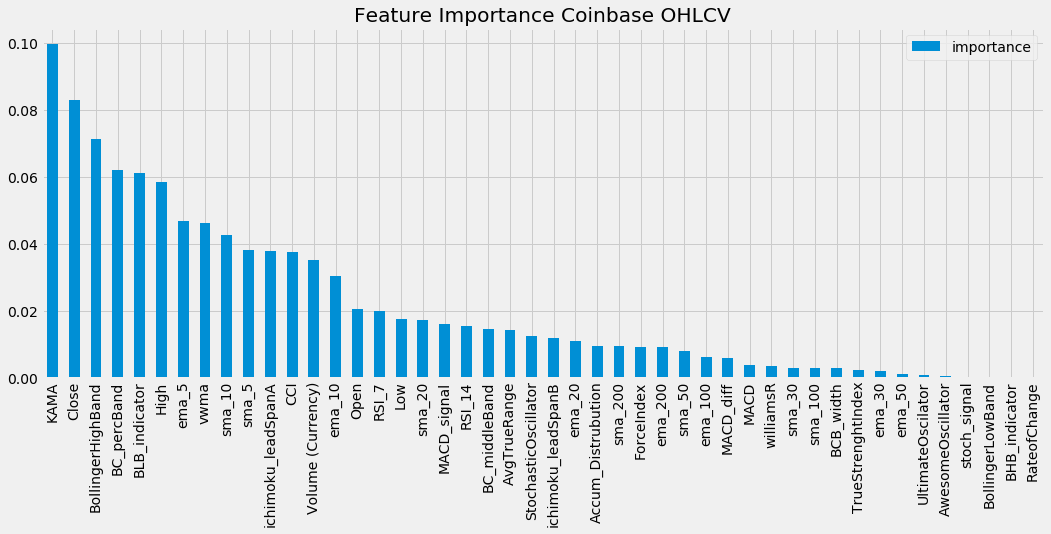

(592, 46)

(592,)

Model Accuracy:  0.9243697478991597


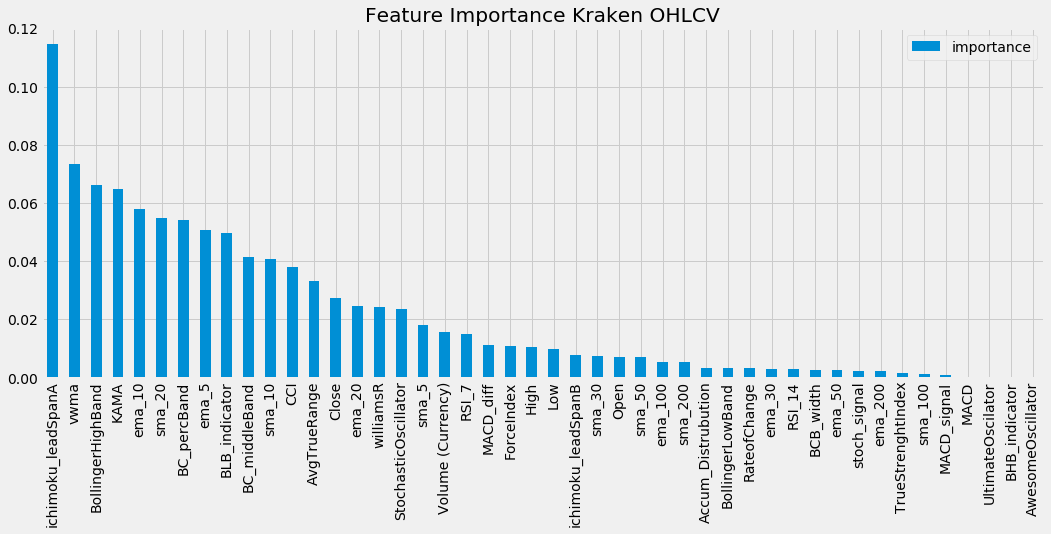

(592, 46)

(592,)

Model Accuracy:  0.9327731092436975


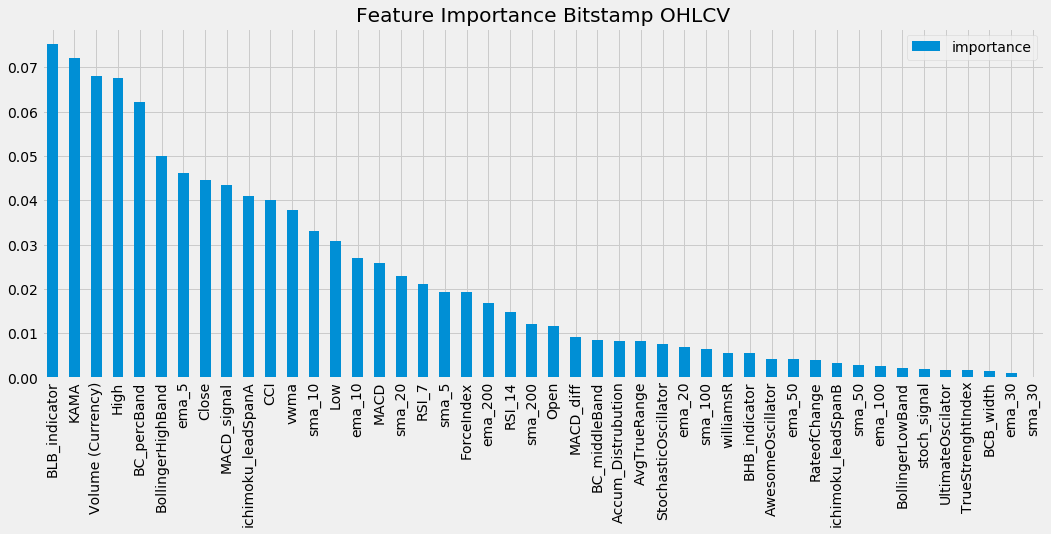

(592, 46)

(592,)

Model Accuracy:  0.9411764705882353


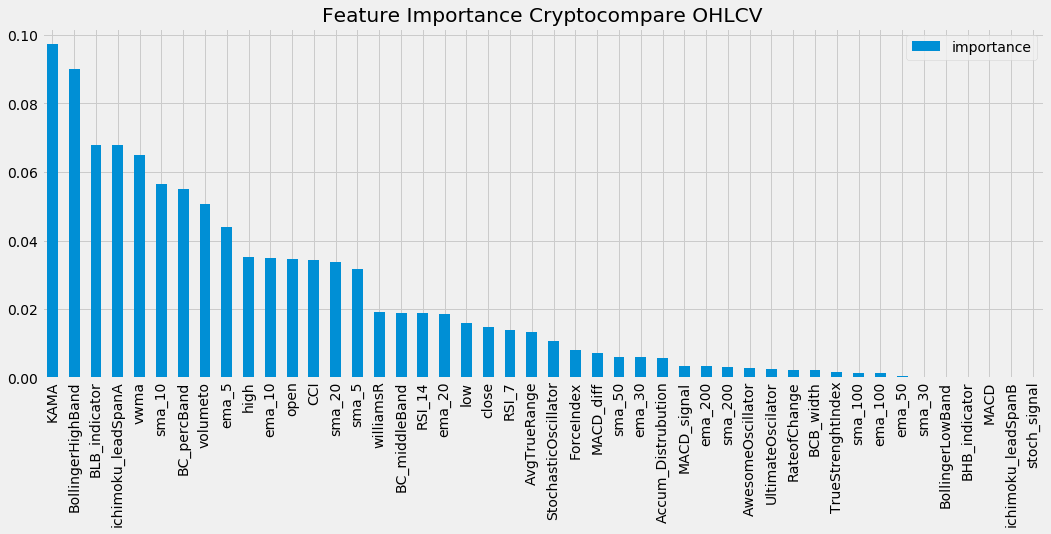

(592, 46)

(592,)

Model Accuracy:  0.9243697478991597


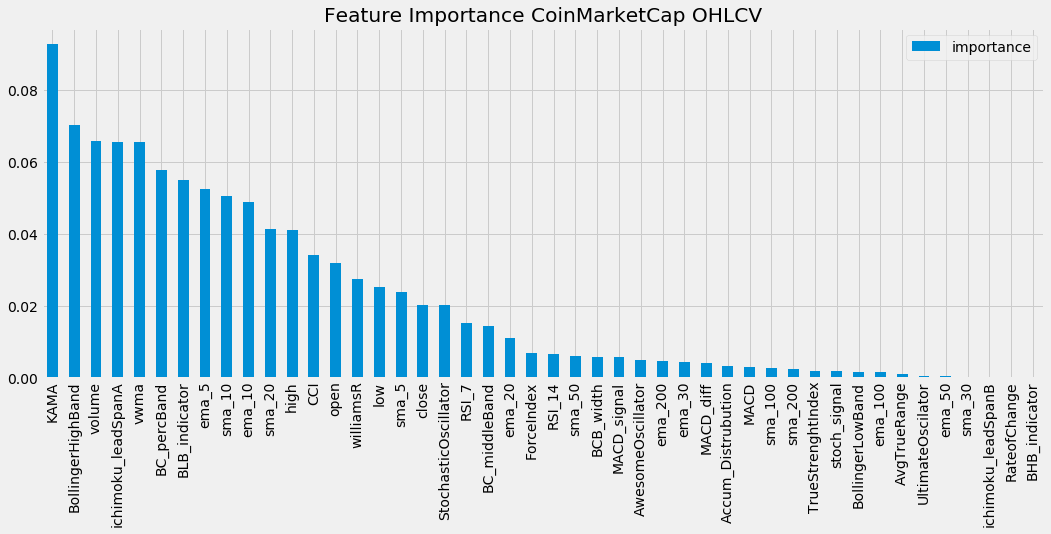

(592, 14)

(592,)

Model Accuracy:  0.773109243697479


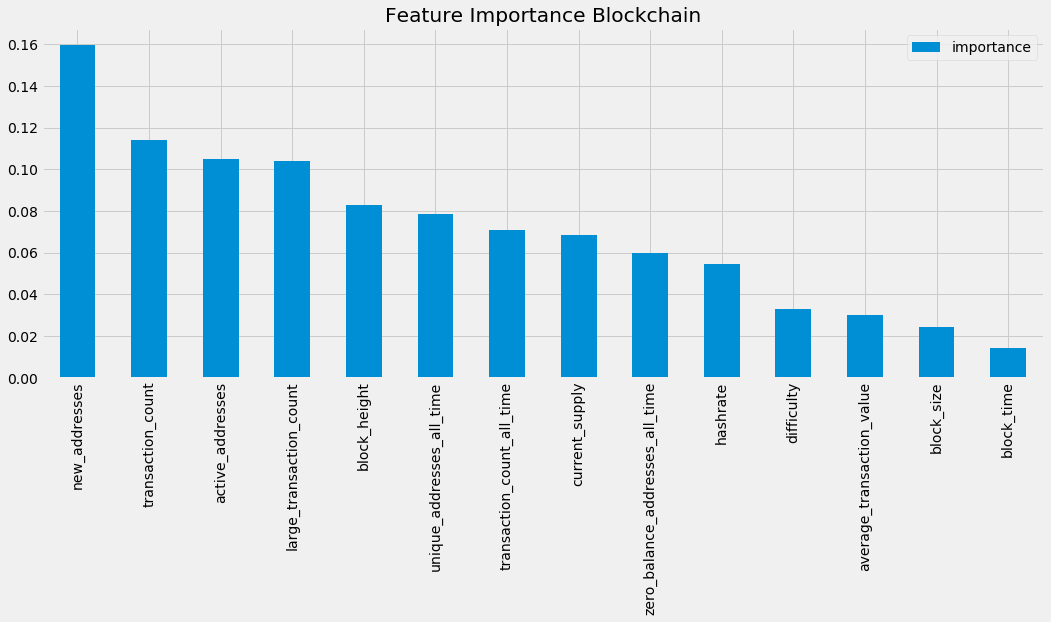

(592, 32)

(592,)

Model Accuracy:  0.8739495798319328


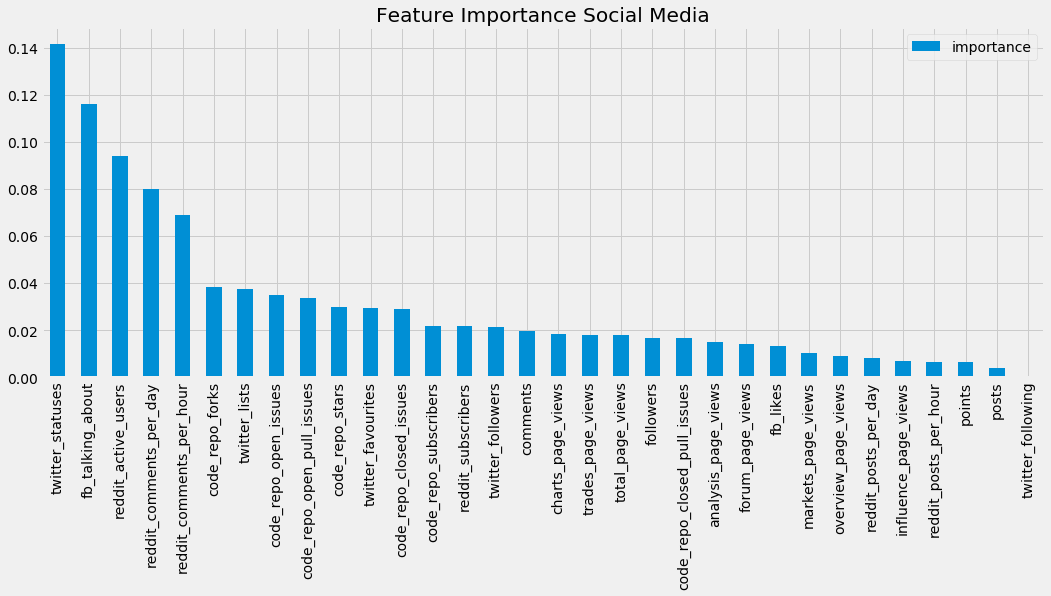

In [63]:
feature_importance(coinbase,coinbase_prices,'Coinbase OHLCV')
feature_importance(kraken,kraken_prices,'Kraken OHLCV')
feature_importance(bitstamp,bitstamp_prices,'Bitstamp OHLCV')
feature_importance(cryptocompare,cryptocompare_prices,'Cryptocompare OHLCV')
feature_importance(coinmarketcap,coinmarketcap_prices,'CoinMarketCap OHLCV')

feature_importance(blockchain,blockchain_data,'Blockchain')
feature_importance(social,social_data,'Social Media')

## Coinbase classification prediction - Random forest

In [135]:
# select X and y
#'Volume (Currency)','AvgTrueRange','sma_5','sma_10','KAMA','vwma','MACD_signal'
X = coinbase_prices[['KAMA','BollingerHighBand','BC_percBand','BLB_indicator','High']]
y = coinbase_prices['anomaly']

# lists for f1-score and AUC
f1_score_lst = []
auc_lst = []
f1_scores = []
roc_scores = []

#loop to calculate f1 and auc scores and present averages after 10 runs
for count in range (1,10):

    # create training and testing vars
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle = True)
    
    # this is the formula after you split the dataset
    sm = SMOTE(random_state=123, sampling_strategy = 'minority')
    x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

    # fit model no training data
    clf = RandomForestClassifier(random_state=123,class_weight='balanced')
  
    clf.fit(x_train_res, y_train_res)

    # make predictions for test data
    y_pred = clf.predict(X_test)
    predictions = [round(value) for value in y_pred]
    
    #10-fold cross validation
    kfold = model_selection.KFold(n_splits=10, random_state=123, shuffle = True)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring=scoring)
    
    # average is the bias, and std dev is variance
    f1_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='f1')
    roc_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='roc_auc')

    #calculate f1-score and AUC
    clf_roc_auc = roc_auc_score(y_test, y_pred)
    
    #calculate average f1-score and AUC
    f1_score_lst.append(precision_recall_fscore_support(y_test, y_pred, average='weighted')[2])
    auc_lst.append(clf_roc_auc)
    
    
print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

print('average f1 score (bias)', f1_scores.mean())
print('average f1 score (variance)', f1_scores.std())
print('average AUC score (bias)', roc_scores.mean())
print('average AUC score (variance)', roc_scores.std())

# Is our model still predicting just one class?
print('Model is predicting ',np.unique( y_pred ),'class' )

print('Accuracy of classifier on test set: {:.3f}'.format(clf.score(X_test, y_test)))

print("10-fold cross validation average accuracy of clf: %.3f" % (results.mean()))

confusion_matrix_y = confusion_matrix(y_test, y_pred)
print('Confusion Matrix for Classfier:')
print(confusion_matrix_y)

print('Classification Report for Classfier:')
print(classification_report(y_test, y_pred))

F1 0.9052; AUC 0.8331 
average f1 score (bias) 0.955279191060003
average f1 score (variance) 0.035547097079261715
average AUC score (bias) 0.986576251180896
average AUC score (variance) 0.012989961277980546
Model is predicting  [0 1] class
Accuracy of classifier on test set: 0.908
10-fold cross validation average accuracy of clf: 0.958
Confusion Matrix for Classfier:
[[91  4]
 [ 7 17]]
Classification Report for Classfier:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94        95
           1       0.81      0.71      0.76        24

    accuracy                           0.91       119
   macro avg       0.87      0.83      0.85       119
weighted avg       0.90      0.91      0.91       119



**Blockchain**

In [140]:
# select X and y
X = blockchain_data[['new_addresses','transaction_count','active_addresses','large_transaction_count','block_height',
                    'unique_addresses_all_time','transaction_count_all_time']]
y = blockchain_data['anomaly']

# lists for f1-score and AUC
f1_score_lst = []
auc_lst = []
f1_scores = []
roc_scores = []

#loop to calculate f1 and auc scores and present averages after 10 runs
for count in range (1,10):

    # create training and testing vars
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle = True)
    
    # this is the formula after you split the dataset
    sm = SMOTE(random_state=123, sampling_strategy = 'minority')
    x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

    # fit model no training data
    clf = RandomForestClassifier(random_state=123,class_weight='balanced')
  
    clf.fit(x_train_res, y_train_res)

    # make predictions for test data
    y_pred = clf.predict(X_test)
    predictions = [round(value) for value in y_pred]
    
    #10-fold cross validation
    kfold = model_selection.KFold(n_splits=10, random_state=123, shuffle = True)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring=scoring)
    
    # average is the bias, and std dev is variance
    f1_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='f1')
    roc_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='roc_auc')

    #calculate f1-score and AUC
    clf_roc_auc = roc_auc_score(y_test, y_pred)
    
    #calculate average f1-score and AUC
    f1_score_lst.append(precision_recall_fscore_support(y_test, y_pred, average='weighted')[2])
    auc_lst.append(clf_roc_auc)
    
    
print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

print('average f1 score (bias)', f1_scores.mean())
print('average f1 score (variance)', f1_scores.std())
print('average AUC score (bias)', roc_scores.mean())
print('average AUC score (variance)', roc_scores.std())

# Is our model still predicting just one class?
print('Model is predicting ',np.unique( y_pred ),'class' )

print('Accuracy of classifier on test set: {:.3f}'.format(clf.score(X_test, y_test)))

print("10-fold cross validation average accuracy of clf: %.3f" % (results.mean()))

confusion_matrix_y = confusion_matrix(y_test, y_pred)
print('Confusion Matrix for Classfier:')
print(confusion_matrix_y)

print('Classification Report for Classfier:')
print(classification_report(y_test, y_pred))

F1 0.7622; AUC 0.7045 
average f1 score (bias) 0.8920309616364512
average f1 score (variance) 0.041296224811089875
average AUC score (bias) 0.9500042023987119
average AUC score (variance) 0.030248194664712378
Model is predicting  [0 1] class
Accuracy of classifier on test set: 0.756
10-fold cross validation average accuracy of clf: 0.890
Confusion Matrix for Classfier:
[[72 17]
 [12 18]]
Classification Report for Classfier:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        89
           1       0.51      0.60      0.55        30

    accuracy                           0.76       119
   macro avg       0.69      0.70      0.69       119
weighted avg       0.77      0.76      0.76       119



**Social**
- concern = should've I make ratios?

In [148]:
# select X and y
X = social_data[['twitter_statuses','fb_talking_about','reddit_active_users','reddit_comments_per_day',
                 'reddit_comments_per_hour','twitter_lists','code_repo_forks']]
y = social_data['anomaly']

# lists for f1-score and AUC
f1_score_lst = []
auc_lst = []
f1_scores = []
roc_scores = []

#loop to calculate f1 and auc scores and present averages after 10 runs
for count in range (1,10):

    # create training and testing vars
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle = True)
    
    # this is the formula after you split the dataset
    sm = SMOTE(random_state=123, sampling_strategy = 'minority')
    x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

    # fit model no training data
    clf = RandomForestClassifier(random_state=123,class_weight='balanced')
  
    clf.fit(x_train_res, y_train_res)

    # make predictions for test data
    y_pred = clf.predict(X_test)
    predictions = [round(value) for value in y_pred]
    
    #10-fold cross validation
    kfold = model_selection.KFold(n_splits=10, random_state=123, shuffle = True)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring=scoring)
    
    # average is the bias, and std dev is variance
    f1_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='f1')
    roc_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='roc_auc')

    #calculate f1-score and AUC
    clf_roc_auc = roc_auc_score(y_test, y_pred)
    
    #calculate average f1-score and AUC
    f1_score_lst.append(precision_recall_fscore_support(y_test, y_pred, average='weighted')[2])
    auc_lst.append(clf_roc_auc)
    
    
print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

print('average f1 score (bias)', f1_scores.mean())
print('average f1 score (variance)', f1_scores.std())
print('average AUC score (bias)', roc_scores.mean())
print('average AUC score (variance)', roc_scores.std())

# Is our model still predicting just one class?
print('Model is predicting ',np.unique( y_pred ),'class' )

print('Accuracy of classifier on test set: {:.3f}'.format(clf.score(X_test, y_test)))

print("10-fold cross validation average accuracy of clf: %.3f" % (results.mean()))

confusion_matrix_y = confusion_matrix(y_test, y_pred)
print('Confusion Matrix for Classfier:')
print(confusion_matrix_y)

print('Classification Report for Classfier:')
print(classification_report(y_test, y_pred))

F1 0.9596; AUC 0.9742 
average f1 score (bias) 0.9525008002943111
average f1 score (variance) 0.019936088636736914
average AUC score (bias) 0.9907683650169812
average AUC score (variance) 0.00723316603072922
Model is predicting  [0 1] class
Accuracy of classifier on test set: 0.958
10-fold cross validation average accuracy of clf: 0.953
Confusion Matrix for Classfier:
[[92  5]
 [ 0 22]]
Classification Report for Classfier:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        97
           1       0.81      1.00      0.90        22

    accuracy                           0.96       119
   macro avg       0.91      0.97      0.94       119
weighted avg       0.97      0.96      0.96       119



**Prices, blockchain & social anomalies combined**

Different dataset could signal different kind of anomalies that could affect price. For instance:
- Social dataset anomaly could signal anomalies fueled by sentiment
- Blockchain anomaly something that is going on in the blockchain
- Volume anomaly for something that is happening with sell or buy orders 
- I think price is reactive to these anomalies but it could also be artificial

If we focus on only 1 type on anomalies we will capture only 1 type. If we focus on only 1 level we will capture only 1 level (blockchian aspect). Of course it depends for what you want to find anomalies. Moreover, different type of anomalies could have same inherent causes that trigger a domino effect with a delay (or not). e.g. (figurative examples)
- cryptocurrency exchange decides to inflate the volume to attract investors --> higher blockchain activity --> higher social sentiment = more traders 
- investor decides to inflate the price --> price, volume, blockchain activity increases = attracts more traders (e.g. if the do pump and dump many traders get negatively affected when they sell)
- someone starts poosting/emailing that BTC will go up --> increase in activity = price increase

It depends on the method of manipulation and anomaly itself. That is why here we look at the big picture of what is happening across different levels to point regulators/traders where to look for and perhaps where is the anomaly coming from. Regulators could then look into if this anomaly is 'innocent' or not. All anomalies are imposible to detect due to sheer size. However, it could help regulators to those that make a big 'splash'. 

Moreover, it could signal traders if we build a form of probability/forecast model or index for where will this anomaly take the cryptocurrency price. It could also act as an insight that something happened yesterday and if the trader should be bearish or bullish. 

Currently, it's important to note that good data is hard to come by for cryptocurrencies. Even between exchanges there are different prices for the same currency. However, Blockchain data cannot be manipulated. It's decentralized nature and cryptographic algorithm make it immune to attack. In fact, hacking a Blockchain is close to impossible. In a world where cyber security has become a key issue for personal, corporate, and national security, Blockchain is a potentially revolutionary technology. Therefore, if we look bad schemes or manipulation they would most likely come from blockchain or exchange (volume, price, personally made blockchain algorithm) itself (potentially even from the social aspect as we mentioned in the example above).

**Assumption:** Therefore per above we will include anomalies from 3 datasets (eventhough they could be different) that were detected in 3 or more anomaly contamination % and atleast 10 models voted for it. That is so we can be more sure these dates were anomalous. This number was chosen arbitraraly. 

In [188]:
# add all important features from 3 datasets 
three_datasets = pd.concat([coinbase_prices[['KAMA','BollingerHighBand','BC_percBand','BLB_indicator','High']],
blockchain_data[['new_addresses','transaction_count','active_addresses','large_transaction_count','block_height',
                    'unique_addresses_all_time','transaction_count_all_time']],
social_data[['twitter_statuses','fb_talking_about','reddit_active_users','reddit_comments_per_day',
                 'reddit_comments_per_hour','twitter_lists','code_repo_forks']]],axis=1)
# subset anomalies that at least 3 contamination % and >= 10 models voted for date to be an anomaly
cc_sub = coinbase[coinbase.AllContaminations_Vote>=3]
cc_sub = cc_sub[cc_sub.ModelAnomaly_Vote>=10]
block_sub = blockchain[blockchain.AllContaminations_Vote>=3]
block_sub = block_sub[block_sub.ModelAnomaly_Vote>=10]
social_sub = social[social.AllContaminations_Vote>=3]
social_sub = social_sub[social_sub.ModelAnomaly_Vote>=10]
# add all dates together
anom_dates = pd.concat([cc_sub.Date,block_sub.Date,social_sub.Date],axis=0)
# add all anomalies from datasets
three_datasets['anomaly'] = np.where(three_datasets.index.isin(anom_dates), 1, 0) 
print('Data shape: ',three_datasets.shape)
print('Nbr of anomalies: ', len(three_datasets[three_datasets.anomaly==1]))

Data shape:  (592, 20)
Nbr of anomalies:  78


In [189]:
# select X and y
X = three_datasets.drop('anomaly',axis=1)
y = three_datasets.anomaly

# lists for f1-score and AUC
f1_score_lst = []
auc_lst = []
f1_scores = []
roc_scores = []

#loop to calculate f1 and auc scores and present averages after 10 runs
for count in range (1,10):

    # create training and testing vars
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle = True)
    
    # this is the formula after you split the dataset
    sm = SMOTE(random_state=123, sampling_strategy = 'minority')
    x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

    # fit model no training data
    clf = RandomForestClassifier(random_state=123,class_weight='balanced')
  
    clf.fit(x_train_res, y_train_res)

    # make predictions for test data
    y_pred = clf.predict(X_test)
    predictions = [round(value) for value in y_pred]
    
    #10-fold cross validation
    kfold = model_selection.KFold(n_splits=10, random_state=123, shuffle = True)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring=scoring)
    
    # average is the bias, and std dev is variance
    f1_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='f1')
    roc_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='roc_auc')

    #calculate f1-score and AUC
    clf_roc_auc = roc_auc_score(y_test, y_pred)
    
    #calculate average f1-score and AUC
    f1_score_lst.append(precision_recall_fscore_support(y_test, y_pred, average='weighted')[2])
    auc_lst.append(clf_roc_auc)
    
    
print('F1 {:.4f}; AUC {:.4f} '.format(np.mean(f1_score_lst),np.mean(auc_lst)))

print('average f1 score (bias)', f1_scores.mean())
print('average f1 score (variance)', f1_scores.std())
print('average AUC score (bias)', roc_scores.mean())
print('average AUC score (variance)', roc_scores.std())

# Is our model still predicting just one class?
print('Model is predicting ',np.unique( y_pred ),'class' )

print('Accuracy of classifier on test set: {:.3f}'.format(clf.score(X_test, y_test)))

print("10-fold cross validation average accuracy of clf_4: %.3f" % (results.mean()))

confusion_matrix_y = confusion_matrix(y_test, y_pred)
print('Confusion Matrix for Classfier:')
print(confusion_matrix_y)

print('Classification Report for Classfier:')
print(classification_report(y_test, y_pred))

F1 0.9255; AUC 0.8333 
average f1 score (bias) 0.9463231272965487
average f1 score (variance) 0.018585464480927
average AUC score (bias) 0.9876698660639658
average AUC score (variance) 0.008675942194350044
Model is predicting  [0 1] class
Accuracy of classifier on test set: 0.924
10-fold cross validation average accuracy of clf_4: 0.946
Confusion Matrix for Classfier:
[[100   5]
 [  4  10]]
Classification Report for Classfier:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       105
           1       0.67      0.71      0.69        14

    accuracy                           0.92       119
   macro avg       0.81      0.83      0.82       119
weighted avg       0.93      0.92      0.93       119



## Average anomaly probability for all days from all 10 unsupervised models
When we detected anomalies using unsupervised machine learning models the output we collected was also the probability of a certain date being an anomaly or outlier probability. Here is the return value definition from PYOD library models documentation: 
- predict_proba (outlier probability) = For each observation, tells whether or not it should be considered as an outlier according to the fitted model. Return the outlier probability, ranging in [0,1]. (Source: https://pyod.readthedocs.io/en/latest/pyod.models.html)

In [190]:
def anomaly_probability(np_array):
    # after the loop this list will cointain average anomaly probability for all days from all models
    all_avg_prob = []
    # iterate over lists cointaining anomaly probabilities from unsupervised model
    for i in range(0,len(np_array[0])):
        prob_row_lst = []
        for probabilities in np_array:
        # e.g. take the same positioned/indexed row 2nd value from each model and append it to a list (take first row from all models)
            prob_row_lst.append(probabilities[i][1])
        # average the list cointaining probabilities for that day 
        # add this value to the 'master' list outside of the for loop (this will cointain average anomaly probability for all days from all models)
        all_avg_prob.append(np.mean(prob_row_lst))
    return all_avg_prob

In [191]:
# call functions
coinbase_avg_proba = anomaly_probability(coinbase_proba)
blockchain_avg_proba = anomaly_probability(blockchain_proba)
social_avg_proba = anomaly_probability(social_proba)

**Add average daily anomaly probabilities to datasets**

In [192]:
# add these values to the dataset - these feature becomes our target variable for regression
# first we remove taget variable from classification
coinbase_regression = coinbase_prices.drop('anomaly', axis=1)
coinbase_regression['Y'] = coinbase_avg_proba
blockchain_regression = blockchain_data.drop('anomaly', axis=1)
blockchain_regression['Y'] = blockchain_avg_proba
social_regression = social_data.drop('anomaly', axis=1)
social_regression['Y'] = social_avg_proba

In [378]:
coinbase_regression[coinbase_regression.Y<0.15]

,Open,High,Low,Close,Volume (Currency),CCI,ichimoku_leadSpanA,ichimoku_leadSpanB,MACD,MACD_diff,MACD_signal,AwesomeOscillator,KAMA,RateofChange,RSI_7,RSI_14,StochasticOscillator,stoch_signal,TrueStrenghtIndex,UltimateOscilator,williamsR,Accum_Distrubution,ForceIndex,AvgTrueRange,BollingerHighBand,BHB_indicator,BollingerLowBand,BLB_indicator,BC_middleBand,BC_percBand,BCB_width,sma_5,sma_10,sma_20,sma_30,sma_50,sma_100,sma_200,ema_5,ema_10,ema_20,ema_30,ema_50,ema_100,ema_200,vwma,Y
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-06,6532.96,6639.00,6452.20,6600.00,3.412917e+07,53.151930,6319.3650,7187.000,-136.789087,97.207581,-233.996668,-132.478147,6519.280540,7.317248,59.179590,49.870518,80.716345,78.114722,-11.739819,-11.739819,-19.283655,8.406383e+09,7.058190e+08,311.613743,6913.194557,0.0,5870.065443,0.0,6391.6300,0.699755,16.320236,6566.966,6375.371,6391.6300,6554.845000,7005.9050,7648.2836,9402.83185,6454.828706,6517.328713,6837.843994,7149.004471,7655.461290,8179.658442,8101.115335,6351.666208,0.141814
2018-07-08,6753.29,6778.31,6671.00,6701.97,2.217592e+07,88.442000,6412.1300,7187.000,-78.867348,103.091708,-181.959056,-4.760588,6572.457415,10.338657,61.855443,52.090041,86.585331,86.287611,-7.171037,-7.171037,-13.414669,8.410600e+09,9.146021e+08,298.323687,6950.450660,0.0,5862.716340,0.0,6406.5835,0.771561,16.978384,6635.134,6522.513,6406.5835,6493.229000,6945.5278,7643.5560,9298.43000,6537.470490,6553.614391,6827.538702,7122.230442,7619.411462,8150.547843,8085.444239,6350.451176,0.148022
2018-07-09,6701.97,6815.82,6625.00,6664.01,3.487711e+07,85.497818,6430.0700,7187.000,-62.345380,95.690941,-158.036321,41.915471,6582.616390,8.672949,58.857550,51.077299,82.981249,87.042579,-5.845341,-5.845341,-17.018751,8.389983e+09,5.948111e+08,290.644852,6938.907197,0.0,5867.019803,0.0,6402.9635,0.743539,16.740489,6650.442,6568.678,6402.9635,6465.482667,6908.4708,7640.9111,9252.95605,6558.560409,6563.650355,6819.751621,7107.449116,7600.672519,8135.576425,8077.321376,6345.264054,0.145629
2018-08-19,6396.63,6547.34,6328.45,6489.53,2.852157e+07,-39.589755,6729.7100,7139.005,-237.188821,-10.567739,-226.621082,-741.583147,6381.289027,-3.404027,48.306032,43.985019,46.676960,42.992213,-19.371108,-19.371108,-53.323040,8.455574e+09,-6.688203e+08,364.788258,7714.175758,0.0,5686.051242,0.0,6700.1135,0.396168,30.270002,6411.314,6320.283,6700.1135,7126.742000,6941.8058,7089.1277,7965.44770,6478.507854,6671.577206,6850.902089,6968.188952,7247.258214,7749.100532,7856.206437,6698.681094,0.144646
2018-08-22,6475.89,6890.65,6250.00,6359.99,1.140436e+08,-9.467188,6745.1525,7194.000,-211.991813,12.197166,-224.188979,-639.738529,6382.244920,3.481608,44.632264,42.901747,46.433150,48.489925,-17.672896,-17.672896,-53.566850,8.380482e+09,-2.334625e+09,372.117118,7178.556179,0.0,5844.614821,0.0,6511.5855,0.386355,20.485661,6396.158,6359.987,6511.5855,7012.366333,6934.4200,7021.7629,7925.71205,6432.955193,6596.061530,6784.941378,6911.768494,7196.396104,7707.951218,7831.493113,6492.753698,0.144612
2018-08-30,7030.92,7048.66,6790.00,6983.00,5.547142e+07,127.765116,6610.2500,7194.000,22.895126,98.548164,-75.653037,36.300324,6654.969102,9.166688,65.629812,56.291633,83.894079,89.120498,1.579212,1.579212,-16.105921,8.581340e+09,1.768068e+09,309.334035,7098.622062,0.0,5982.676938,0.0,6540.6495,0.896391,17.061687,6941.358,6749.743,6540.6495,6667.705667,6976.9826,6905.8527,7879.78530,6789.127325,6741.103054,6806.306303,6896.384159,7144.205582,7640.589830,7788.174928,6506.684010,0.144841
2018-08-31,6983.00,7090.46,6884.49,7015.01,5.398093e+07,124.070108,6634.9225,7194.000,40.304314,92.765881,-52.461567,133.186706,6709.308953,8.097351,67.135537,57.052672,87.449600,86.960105,3.294831,3.294831,-12.550400,8.595773e+09,1.762334e+09,301.950890,7155.508806,0.0,6003.735194,0.0,6579.6220,0.878015,17.505164,7002.364,6803.655,6579.6220,6648.073000,6992.2878,6900.9528,7870.49895,6826.774438,6766.003685,6816.244574,6900.210800,7141.672071,7634.333522,7783.904081,6544.118

### Correlation to Target variable - Average daily anomaly probability

In [193]:
# correlation function
def correlation_y(df):
    corr = df.drop("Y", axis=1).apply(lambda x: x.corr(df.Y))
    print('Positive Correlation >= 0.2 to Y: ')
    display(corr[corr>=0.2].sort_values(ascending=False))
    print('\n','Negative Correlation <= -0.2 to Y: ')
    display(corr[corr<=-0.2])

## Linear Regression
**Coinbase prices dataset**
**Correlation to to the target:**

In [203]:
correlation_y(coinbase_regression)

Positive Correlation >= 0.2 to Y: 


Volume (Currency)     0.714291
AvgTrueRange          0.616570
BCB_width             0.530068
High                  0.516684
BollingerHighBand     0.513562
sma_10                0.505117
vwma                  0.505021
sma_5                 0.504769
KAMA                  0.493171
Open                  0.490047
Close                 0.489533
sma_20                0.482536
ema_5                 0.471480
ichimoku_leadSpanA    0.456066
Low                   0.442401
sma_30                0.438330
ema_10                0.436878
BC_middleBand         0.432971
MACD_signal           0.417952
MACD                  0.381091
ichimoku_leadSpanB    0.370910
BLB_indicator         0.368889
ema_20                0.363020
sma_50                0.359198
AwesomeOscillator     0.312585
BHB_indicator         0.306221
ema_30                0.291031
BollingerLowBand      0.267397
dtype: float64


 Negative Correlation <= -0.2 to Y: 


sma_200   -0.319886
dtype: float64

In [ ]:
# add 51 49 % to see what makes the difference 

**Average anomaly probability density**

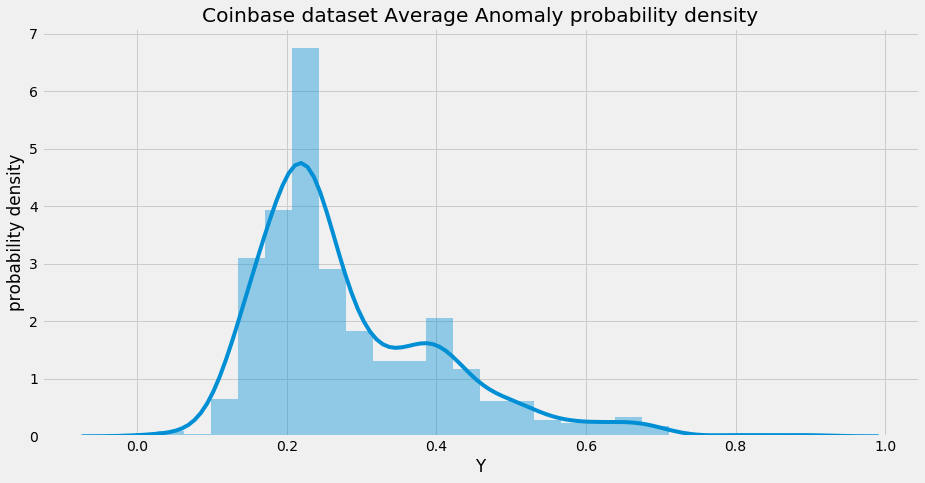

In [210]:
sns.distplot(coinbase_regression['Y'])
plt.title('Coinbase dataset Average Anomaly probability density')
plt.ylabel('probability density')
plt.show()

In [ ]:
# remove t below 2 

In [208]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
# scale data
data = scale(coinbase_regression)

X = data[["Volume (Currency)",'AvgTrueRange','BCB_width','High','BollingerHighBand','vwma','sma_10','sma_5']]
y = data["Y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123)

# Note the difference in argument order
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test) # make the predictions by the model
# 10-cross validation
# innitialize the model
lin_reg = LinearRegression()
# Train model
lin_reg.fit(X_train, y_train)
scoring = 'neg_mean_squared_error'
results = model_selection.cross_val_score(lin_reg, X_train, y_train, cv=10, scoring=scoring)

# Display 10-fold cross validation average accuracy
print("10-fold cross validation average negative MSE of lin_reg: %.10f" % (results.mean()))
# Print out the statistics
model.summary()

10-fold cross validation average negative MSE of lin_reg: -0.0092428936


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.892
Model:                            OLS   Adj. R-squared (uncentered):              0.890
Method:                 Least Squares   F-statistic:                              479.8
Date:                Wed, 03 Jun 2020   Prob (F-statistic):                   3.19e-219
Time:                        22:34:10   Log-Likelihood:                          378.71
No. Observations:                 473   AIC:                                     -741.4
Df Residuals:                     465   BIC:                                     -708.1
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Volume (Currency)     0.3231      0.075      4.291      0.000       0.175       0.471
AvgTrueRange          0.2975      0.074      4.029      0.000       0.152       0.443
BCB_width             0.6040      0.027     22.386      0.000       0.551       0.657
High                 -0.0100      0.174     -0.057      0.954      -0.352       0.332
BollingerHighBand    -1.5080      0.155     -9.732      0.000      -1.812      -1.203
vwma                  0.6344      0.131      4.832      0.000       0.376       0.892
sma_10                0.8164      0.214      3.810      0.000       0.395       1.237
sma_5                -0.0215      0.239     -0.090      0.928      -0.491       0.448
==============================================================================
Omnibus:                      139.037   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              365.442
Skew:                           1.445   Prob(JB):                     4.42e-80
Kurtosis:                       6.192   Cond. No.                         57.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Blockchain Dataset**

In [198]:
# correlation to target feature
correlation_y(blockchain_regression)

Positive Correlation >= 0.2 to Y: 


large_transaction_count      0.329249
transaction_count            0.323501
average_transaction_value    0.310083
new_addresses                0.304968
dtype: float64


 Negative Correlation <= -0.2 to Y: 


Series([], dtype: float64)

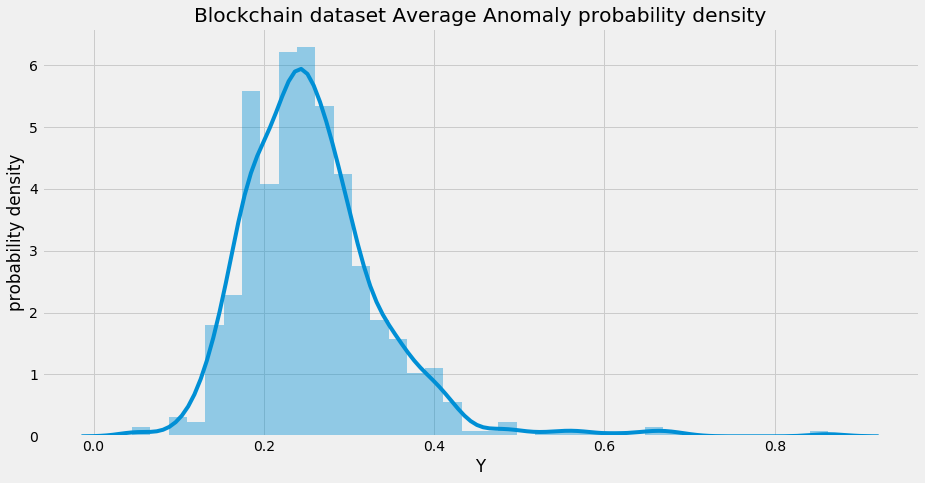

In [209]:
sns.distplot(blockchain_regression['Y'])
plt.title('Blockchain dataset Average Anomaly probability density')
plt.ylabel('probability density')
plt.show()

**Linear regression Blockchain**

In [211]:
# scale data
data = scale(blockchain_regression)

X = data[['large_transaction_count','transaction_count','average_transaction_value','new_addresses']]
y = data["Y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123)

# Note the difference in argument order
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test) # make the predictions by the model
# 10-cross validation
# innitialize the model
lin_reg = LinearRegression()
# Train model
lin_reg.fit(X_train, y_train)
scoring = 'neg_mean_squared_error'
results = model_selection.cross_val_score(lin_reg, X_train, y_train, cv=10, scoring=scoring)

# Display 10-fold cross validation average accuracy
print("10-fold cross validation average negative MSE of lin_reg: %.10f" % (results.mean()))
# Print out the statistics
model.summary()

10-fold cross validation average negative MSE of lin_reg: -0.0077471894


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.865
Model:                            OLS   Adj. R-squared (uncentered):              0.864
Method:                 Least Squares   F-statistic:                              752.1
Date:                Wed, 03 Jun 2020   Prob (F-statistic):                   1.87e-202
Time:                        22:36:07   Log-Likelihood:                          414.07
No. Observations:                 473   AIC:                                     -820.1
Df Residuals:                     469   BIC:                                     -803.5
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
large_transaction_count       0.4857      0.096      5.063      0.000       0.297       0.674
transaction_count             1.3070      0.093     14.029      0.000       1.124       1.490
average_transaction_value     0.8215      0.053     15.453      0.000       0.717       0.926
new_addresses                -1.2605      0.150     -8.376      0.000      -1.556      -0.965
==============================================================================
Omnibus:                       90.130   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.196
Skew:                           1.115   Prob(JB):                     7.34e-35
Kurtosis:                       4.734   Cond. No.                         20.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Social dataset**

In [202]:
# correlation to target feature
correlation_y(social_regression)

Positive Correlation >= 0.2 to Y: 


fb_talking_about            0.450208
reddit_comments_per_hour    0.427317
reddit_comments_per_day     0.427317
reddit_posts_per_day        0.358082
reddit_posts_per_hour       0.358079
reddit_active_users         0.236718
dtype: float64


 Negative Correlation <= -0.2 to Y: 


comments                       -0.278448
posts                          -0.290607
followers                      -0.282743
points                         -0.287315
overview_page_views            -0.304555
analysis_page_views            -0.294440
markets_page_views             -0.302516
charts_page_views              -0.326148
trades_page_views              -0.303634
forum_page_views               -0.303270
influence_page_views           -0.305563
total_page_views               -0.308778
fb_likes                       -0.251799
twitter_followers              -0.360134
twitter_lists                  -0.372288
twitter_favourites             -0.393342
twitter_statuses               -0.541325
reddit_subscribers             -0.277175
code_repo_stars                -0.424029
code_repo_forks                -0.437883
code_repo_subscribers          -0.456807
code_repo_open_pull_issues     -0.587119
code_repo_closed_pull_issues   -0.561726
code_repo_open_issues          -0.506894
code_repo_closed

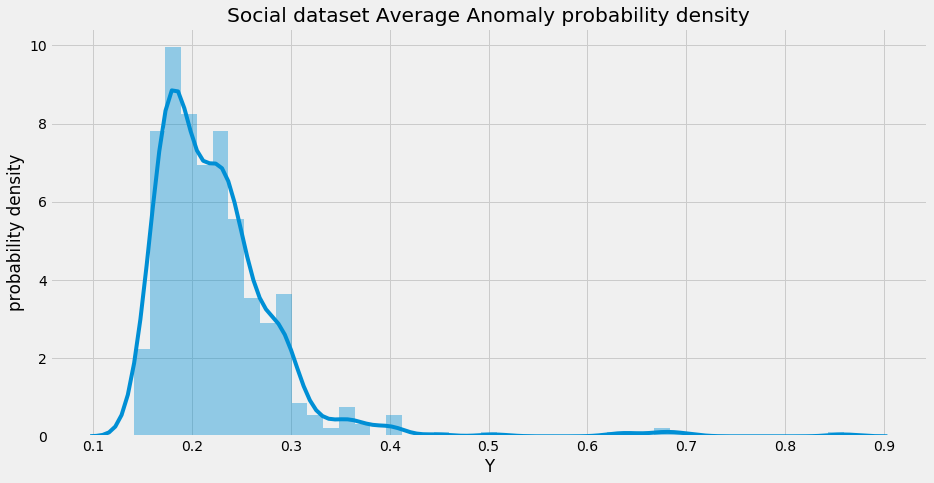

In [212]:
sns.distplot(social_regression['Y'])
plt.title('Social dataset Average Anomaly probability density')
plt.ylabel('probability density')
plt.show()

**Linear regression Social dataset**

In [216]:
# replace 6 nan Y values with mean
social_regression.Y = social_regression.Y.fillna(social_regression.Y.mean())

In [222]:
# scale data
data = scale(social_regression)

X = data[['fb_talking_about','reddit_comments_per_hour','reddit_posts_per_hour',
         'comments','posts']]
y = data["Y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123)

# Note the difference in argument order
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test) # make the predictions by the model
# 10-cross validation
# innitialize the model
lin_reg = LinearRegression()
# Train model
lin_reg.fit(X_train, y_train)
scoring = 'neg_mean_squared_error'
results = model_selection.cross_val_score(lin_reg, X_train, y_train, cv=10, scoring=scoring)

# Display 10-fold cross validation average accuracy
print("10-fold cross validation average negative MSE of lin_reg: %.10f" % (results.mean()))
# Print out the statistics
model.summary()

10-fold cross validation average negative MSE of lin_reg: -0.0070025308


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.715
Model:                            OLS   Adj. R-squared (uncentered):              0.712
Method:                 Least Squares   F-statistic:                              235.2
Date:                Wed, 03 Jun 2020   Prob (F-statistic):                   3.50e-125
Time:                        22:41:08   Log-Likelihood:                          509.61
No. Observations:                 473   AIC:                                     -1009.
Df Residuals:                     468   BIC:                                     -988.4
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
fb_talking_about             0.2167      0.026      8.260      0.000       0.165       0.268
reddit_comments_per_hour     0.1149      0.018      6.211      0.000       0.079       0.151
reddit_posts_per_hour        0.0822      0.028      2.932      0.004       0.027       0.137
comments                     0.5595      0.125      4.490      0.000       0.315       0.804
posts                       -0.5222      0.117     -4.454      0.000      -0.753      -0.292
==============================================================================
Omnibus:                      530.375   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45457.232
Skew:                           5.005   Prob(JB):                         0.00
Kurtosis:                      49.971   Cond. No.                         40.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [299]:
import cbpro
public_client = cbpro.PublicClient()
# Get the order book at the default level.
public_client.get_product_order_book('BTC-USD',level=1)

{'sequence': 14521270416,
 'bids': [['9823.15', '0.50546439', 6]],
 'asks': [['9823.16', '0.02', 1]]}

In [286]:
# Get the product ticker for a specific product.
public_client.get_product_ticker(product_id='ETH-USD')

{'trade_id': 58962863,
 'price': '243.91',
 'size': '0.32964857',
 'time': '2020-06-04T17:46:51.872476Z',
 'bid': '243.9',
 'ask': '243.91',
 'volume': '161077.06492789'}

In [300]:
#public_client.get_product_historic_rates('ETH-USD')
# To include other parameters, see function docstring:
public_client.get_product_historic_rates('BTC-USD', granularity=86400)

[[1591228800, 9450, 9869.19, 9668.06, 9824.99, 8879.34003463],
 [1591142400, 9385.22, 9695, 9521.53, 9668.07, 11446.72193696],
 [1591056000, 9270, 10237.6, 10208.96, 9522.46, 33220.59282341],
 [1590969600, 9417.42, 10428, 9445.83, 10208.96, 21676.60828748],
 [1590883200, 9369.58, 9705.6, 9700.32, 9446.57, 7944.71669301],
 [1590796800, 9326.43, 9764, 9423.85, 9700.33, 10509.70845135],
 [1590710400, 9330.01, 9609.02, 9580.01, 9423.84, 10415.42644355],
 [1590624000, 9112, 9625, 9208.53, 9580.19, 14511.07649252],
 [1590537600, 8811.46, 9230, 8844.41, 9208.53, 10936.69462637],
 [1590451200, 8694.23, 9016.99, 8900, 8844.42, 11507.43097855],
 [1590364800, 8632.93, 8977, 8715.69, 8899.31, 12328.24203695],
 [1590278400, 8680.7, 9306.23, 9181.09, 8715.73, 13004.34567862],
 [1590192000, 9090.11, 9313.83, 9168.84, 9181.76, 6878.84791748],
 [1590105600, 8923.5, 9267.34, 9059.32, 9168.84, 13731.91887098],
 [1590019200, 8800, 9568, 9509.4, 9061.96, 28081.22890941],
 [1589932800, 9294.54, 9836.99, 978

In [291]:
public_client.get_product_24hr_stats('ETH-USD')

{'open': '239.54000000',
 'high': '246.73000000',
 'low': '236.17000000',
 'volume': '161077.06492789',
 'last': '244.00000000',
 'volume_30day': '4775306.35359543'}

In [296]:
public_client.get_product_trades(product_id='BTC-USD')

<generator object PublicClient._send_paginated_message at 0x7fe39cac7550>

In [297]:
public_client.get_time()

{'iso': '2020-06-04T17:52:44.758Z', 'epoch': 1591293164.758}

In [379]:
5/2

2.5